In [1]:
run ='amery'
vers='v10km'
plotting = True

import numpy as np 
import matplotlib.pyplot as plt
import os
import sys
import xarray as xr
import scipy.io as sio
import datetime
import cmocean
# import h5py
import bathy_smoother
# import pyresample

#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.uvp_masks import uvp_masks

# %load_ext autoreload
# %autoreload 1
# %aimport tools.inverse_polar_stereo,tools.cartesian_grid_2d,tools.NDinterp,tools.smoothing_PlusMinus_rx0,tools.uvp_masks

out_path = os.path.join(data_dir,'proc',run+'_'+vers+'_extracted_grd.nc')

In [2]:
in_file='/home/woden/Documents/amery-hires-setup/data/proc/waom10_grd.nc'
waom10 = xr.open_dataset(in_file)

In [3]:
waom10



<xarray.Dataset>
Dimensions:    (eta_rho: 530, xi_rho: 630, eta_psi: 529, xi_psi: 629,
                eta_u: 530, xi_u: 629, eta_v: 529, xi_v: 630)
Dimensions without coordinates: eta_rho, xi_rho, eta_psi, xi_psi, eta_u, xi_u,
                                eta_v, xi_v
Data variables: (12/24)
    spherical  int64 ...
    xl         int64 ...
    el         int64 ...
    angle      (eta_rho, xi_rho) float64 ...
    pm         (eta_rho, xi_rho) float64 ...
    pn         (eta_rho, xi_rho) float64 ...
    ...         ...
    lon_v      (eta_v, xi_v) float64 ...
    lat_v      (eta_v, xi_v) float64 ...
    mask_rho   (eta_rho, xi_rho) float64 ...
    mask_psi   (eta_psi, xi_psi) float64 ...
    mask_u     (eta_u, xi_u) float64 ...
    mask_v     (eta_v, xi_v) float64 ...
Attributes:
    history:  GRID file using make_grid.py,2018-06-28
    type:     ROMS grid file

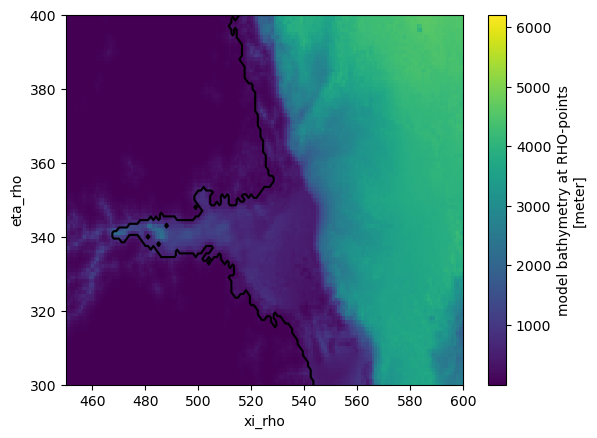

In [4]:
xi_lims=(450,600)
eta_lims=(300,400)
plt.figure()
waom10.h.plot() #.isel(xi_rho=slice(*xi_lims),eta_rho=slice(*eta_lims)).plot()
waom10.mask_rho.plot.contour(levels=np.array([0.5]),colors='k') #.isel(xi_rho=slice(*xi_lims),eta_rho=slice(*eta_lims)).plot.contour(levels=np.array([0.5]),colors='k')
plt.xlim(*xi_lims)
plt.ylim(*eta_lims)
plt.show()

In [5]:
# set subsetting bounds
xi_lims=(450,600) #will be specific to the input grid
eta_lims=(300,400)
input_file = waom10 #specify the input gridfile name from above

In [6]:
#Subset original grid

new_grid = input_file.isel(xi_rho=slice(*xi_lims),eta_rho=slice(*eta_lims))

new_grid

<xarray.Dataset>
Dimensions:    (eta_rho: 100, xi_rho: 150, eta_psi: 529, xi_psi: 629,
                eta_u: 530, xi_u: 629, eta_v: 529, xi_v: 630)
Dimensions without coordinates: eta_rho, xi_rho, eta_psi, xi_psi, eta_u, xi_u,
                                eta_v, xi_v
Data variables: (12/24)
    spherical  int64 ...
    xl         int64 ...
    el         int64 ...
    angle      (eta_rho, xi_rho) float64 ...
    pm         (eta_rho, xi_rho) float64 ...
    pn         (eta_rho, xi_rho) float64 ...
    ...         ...
    lon_v      (eta_v, xi_v) float64 ...
    lat_v      (eta_v, xi_v) float64 ...
    mask_rho   (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_psi   (eta_psi, xi_psi) float64 ...
    mask_u     (eta_u, xi_u) float64 ...
    mask_v     (eta_v, xi_v) float64 ...
Attributes:
    history:  GRID file using make_grid.py,2018-06-28
    type:     ROMS grid file

In [7]:
#re-calculate the geographic coordinates

# eta_rho_lims = eta_lims
# xi_rho_lims = xi_lims

# xi_psi_lims = (xi_lims[0]+1,xi_lims[1]-1)
# eta_psi_lims = (eta_lims[0]+1,eta_lims[1]-1)

# #note that eta_v = eta_rho-1, xi_u = xi_rho-1. Other dimensions for u/v are the rho equivalent.
# xi_u_lims = (xi_lims[0]+1,xi_lims[1]-1)
# eta_v_lims = (eta_lims[0]+1,eta_lims[1]-1)


In [8]:
# make the u,v,psi grids

def arakawa_c_grid(lon_rho, lat_rho):
    # Code written by chatGPT, so who knows if it's reliable..
    # Define the shape of the grid
    M, L = lon_rho.shape

    # Compute the coordinates for the u points
    lon_u = np.zeros((M, L-1))
    lat_u = np.zeros((M, L-1))
    for i in range(M):
        for j in range(L-1):
            lon_u[i,j] = 0.5*(lon_rho[i,j]+lon_rho[i,j+1])
            lat_u[i,j] = 0.5*(lat_rho[i,j]+lat_rho[i,j+1])
    print('made u points')

    # Compute the coordinates for the v points
    lon_v = np.zeros((M-1, L))
    lat_v = np.zeros((M-1, L))
    for i in range(M-1):
        for j in range(L):
            lon_v[i,j] = 0.5*(lon_rho[i,j]+lon_rho[i+1,j])
            lat_v[i,j] = 0.5*(lat_rho[i,j]+lat_rho[i+1,j])
    print('made v points')

    # Compute the coordinates for the psi points
    lon_psi = np.zeros((M-1, L-1))
    lat_psi = np.zeros((M-1, L-1))
    for i in range(M-1):
        for j in range(L-1):
            lon_psi[i,j] = 0.25*(lon_rho[i,j]+lon_rho[i,j+1]+lon_rho[i+1,j]+lon_rho[i+1,j+1])
            lat_psi[i,j] = 0.25*(lat_rho[i,j]+lat_rho[i,j+1]+lat_rho[i+1,j]+lat_rho[i+1,j+1])
    print('made psi points')

    # # Create xarray DataArrays for the u, v, and psi coordinates
    # lon_u_da = xr.DataArray(lon_u, dims=('eta_u', 'xi_u'))
    # lat_u_da = xr.DataArray(lat_u, dims=('eta_u', 'xi_u'))
    # lon_v_da = xr.DataArray(lon_v, dims=('eta_v', 'xi_v'))
    # lat_v_da = xr.DataArray(lat_v, dims=('eta_v', 'xi_v'))
    # lon_psi_da = xr.DataArray(lon_psi, dims=('eta_psi', 'xi_psi'))
    # lat_psi_da = xr.DataArray(lat_psi, dims=('eta_psi', 'xi_psi'))

    return lon_u, lat_u, lon_v, lat_v, lon_psi, lat_psi



lon_rho = new_grid.lon_rho.values
lat_rho = new_grid.lat_rho.values

lon_u, lat_u, lon_v, lat_v, lon_psi, lat_psi = arakawa_c_grid(lon_rho, lat_rho)



made u points
made v points
made psi points


In [9]:
# make the x_rho and y_rho variables
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")


x_rho,y_rho = ll_to_ps.transform(lat_rho,lon_rho)

x_rho_da = xr.DataArray(x_rho,name='x_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'x-coordinate of rho points', 'units': 'meter'} )
y_rho_da = xr.DataArray(y_rho,name='y_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'y-coordinate of rho points', 'units': 'meter'} )


In [10]:
#recalculate the masks

mask = new_grid.mask_rho

mask_u,mask_v,mask_psi = uvp_masks(mask)

mask_rho_da = xr.DataArray(mask,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

In [11]:
#extract arrays and save to xarray dataset 

xl = np.maximum((1/new_grid.pm[0,:]).sum(), (1/new_grid.pn[-1,:]).sum())
el = np.maximum((1/new_grid.pm[:,0]).sum(), (1/new_grid.pn[:,-1]).sum())

angle = new_grid.angle
pm = new_grid.pm
pn = new_grid.pn
dmde = new_grid.dmde
dndx = new_grid.dndx
f = new_grid.f
h = new_grid.h
zice = new_grid.zice

#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray(int(1),name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array([0, 1], dtype=int),
 'long_name': 'grid type logical switch'})


xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(h,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(zice,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})



grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pn_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
              #   'hraw':hraw_da,
                'zice':zice_da,
              #   'zice_raw':zice_raw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file extracted from '+in_file+' on the '+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

In [12]:
grd

<xarray.Dataset>
Dimensions:    (eta_rho: 100, xi_rho: 150, eta_psi: 99, xi_psi: 149,
                eta_u: 100, xi_u: 149, eta_v: 99, xi_v: 150)
Dimensions without coordinates: eta_rho, xi_rho, eta_psi, xi_psi, eta_u, xi_u,
                                eta_v, xi_v
Data variables: (12/23)
    spherical  int64 1
    xl         float64 1.485e+06
    el         float64 1.004e+06
    angle      (eta_rho, xi_rho) float64 1.371 1.372 1.373 ... 1.16 1.161 1.163
    pm         (eta_rho, xi_rho) float64 9.918e-05 9.92e-05 ... 0.0001043
    pn         (eta_rho, xi_rho) float64 9.918e-05 9.92e-05 ... 0.0001043
    ...         ...
    lon_v      (eta_v, xi_v) float64 78.36 78.44 78.51 ... 66.56 66.63 66.7
    lat_v      (eta_v, xi_v) float64 -75.93 -75.84 -75.75 ... -60.7 -60.62
    mask_rho   (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_psi   (eta_psi, xi_psi) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_u     (eta_u, xi_u) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    mask_v     (eta_v, xi_v) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    history:  GRID file extracted from /home/woden/Documents/amery-hires-setu...
    type:     ROMS grid file

In [13]:
#output netcdf
grd.to_netcdf(out_path,unlimited_dims='bath')

In [14]:
20*20


400

In [15]:
STOP HERE

SyntaxError: invalid syntax (3031286301.py, line 1)

In [ ]:
mr = 2
grid_xLims= (1500,3300) #km
grid_yLims= (0,1500) #km
#establish the grid with grid point distances of mr/2 in km
#we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
#we need an extra line of u and v points at first to calculate all dx and dy on rho points
x,y = np.meshgrid(np.arange(grid_xLims[0],grid_xLims[1]+mr/2,mr/2),np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2))
x_rho = x[1::2,1::2]
y_rho = y[1::2,1::2]

In [ ]:
#load geometry
bedmachine_v3_path = os.path.join(data_dir,'raw','BedMachineAntarctica-v3','BedMachineAntarctica-v3.nc')

bm3 = xr.load_dataset(bedmachine_v3_path)


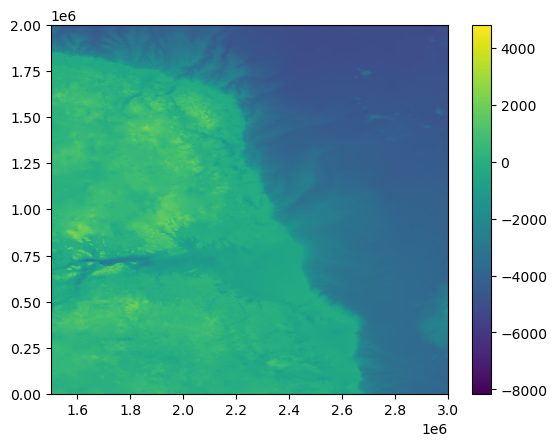

In [ ]:
# specific for bedmachine
bathy = bm3.bed
Xval = bm3.x
Yval = bm3.y


plt.pcolormesh(Xval,Yval,bathy)
plt.colorbar()
plt.axis([1.5e6,3e6,0,2e6])
plt.show()


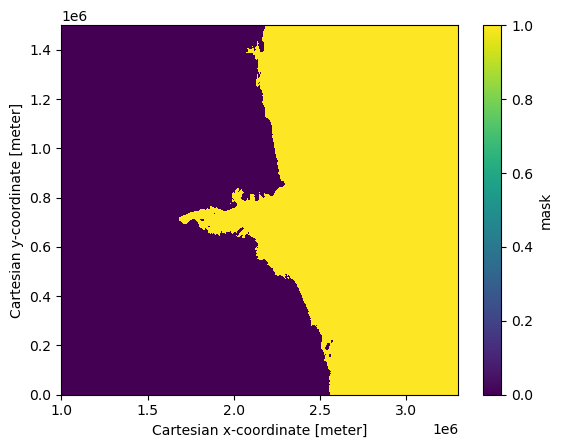

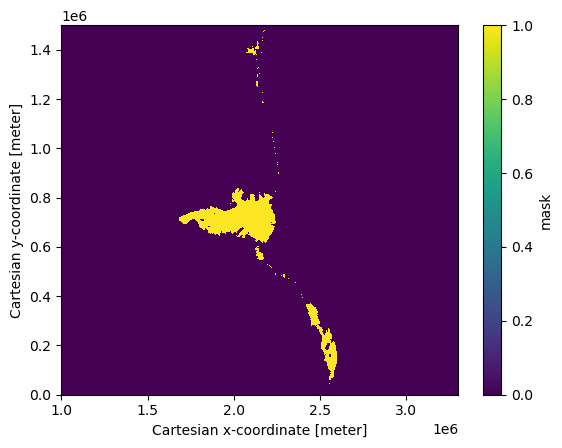

In [ ]:
#subset bedmachine dataset
geom=bm3.sel(x=slice(1e6,3.3e6)).sel(y=slice(1.5e6,0)) # note reversed y coord

# make XX and YY coordinates
XX,YY = np.meshgrid(geom.x,geom.y)
geom = geom.assign_coords({"XX": (("y", "x"), XX), "YY": (("y", "x"), YY)})

# make 'draft' abd 'bathy' variables
geom["draft"]=-(geom.thickness-geom.surface) #draft is negative
geom["bathy"]=-geom.bed # bathy is postive

# make masks
geom["mask_ice"]=np.isfinite(geom.mask.where(geom.mask==3,np.NaN))
geom["mask_ocean"]=np.isfinite(geom.mask.where((geom.mask==0)|(geom.mask==3),np.NaN))

geom.mask_ocean.plot()
plt.show()
geom.mask_ice.plot()

# convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

geom_lat,geom_lon = ps_to_ll.transform(geom.XX,geom.YY)

geom = geom.assign_coords({"lon": (("y", "x"), geom_lon), "lat": (("y", "x"), geom_lat)})



In [ ]:
#load south polar stereographic projection to convert from grid point distance in m to lat/lon and back
#from mpl_toolkits.basemap import Basemap
#m = Basemap(projection='spstere',lon_0=0,boundinglat=-50,lat_ts=-71.0,ellps='WGS84')

#get lat/lon coordinates at all grid points by shifting the grid to the lower left corner of the map
#lonBM,latBM=m(x*1000+m.urcrnrx/2,y*1000+m.urcrnry/2,inverse=True)
lat,lon = inverse_polar_stereo(x,y,0,0,-71.0)
#calculate curvilinear coordinate distances at rho points
dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])

# dx2 = ((x[1::2,0:-2:2] - x[1::2,2::2])**2 + (y[1::2,0:-2:2]-y[1::2,2::2])**2)**0.5
# dy2 = ((x[0:-2:2,1::2] - x[2::2,1::2])**2 + (y[0:-2:2,1::2]-y[2::2,1::2])**2)**0.5

#calculate curvilinear coordinate metrices
pm = 1.0/dx
pn = 1.0/dy
 
dndx = np.empty_like(pm)
dmde = np.empty_like(pn)

dndx[:,1:-1] = 0.5*(pn[:,2:] - pn[:,:-2])
dmde[1:-1,:] = 0.5*(pm[2:,:] - pm[:-2,:])

dndx[:,0]  = 2*dndx[:,1]  - dndx[:,2]
dndx[:,-1] = 2*dndx[:,-2] - dndx[:,-3]
dmde[0,:]  = 2*dmde[1,:]  - dmde[2,:]
dmde[-1,:] = 2*dmde[-2,:] - dmde[-3,:]

#subset lat and lon at rho, psi, u and v points
lon_rho = lon[1::2,1::2]
lat_rho = lat[1::2,1::2]
#lon_rhoBM = lonBM[1::2,1::2]
#lat_rhoBM = latBM[1::2,1::2]

lon_psi = lon[2:-1:2,2:-1:2]
lat_psi = lat[2:-1:2,2:-1:2]

lon_u = lon[1::2,2:-1:2]
lat_u = lat[1::2,2:-1:2]

lon_v = lon[2:-1:2,1::2]
lat_v = lat[2:-1:2,1::2]

In [ ]:
lat_s = geom.lat.values.flatten()
lon_s = geom.lon.values.flatten()

In [ ]:
# interpolate from the bm3 grid to the new roms grid

from scipy.interpolate import griddata

def grid_data(data):
    return griddata((lon_s,lat_s),data,(lon_rho,lat_rho),'nearest')

roms_tmp_bm3 = {}
for key in ['bathy','draft','mask_ice','mask_ocean']:
    roms_tmp_bm3[key] = grid_data(geom[key].values.flatten())

In [ ]:
# interpolate from the waom2 grid to the new roms grid

# def grid_waom2(data):
#     return griddata((waom2.lon_rho.values.flatten(),waom2.lat_rho.values.flatten()),data,(lon_rho,lat_rho),'nearest')

# roms_tmp = {}
# for key in ['h','zice','mask_rho']:
#     roms_tmp[key] = grid_data(waom2[key].values.flatten())

roms_tmp['h']=griddata((waom2.lon_rho.values.flatten(),waom2.lat_rho.values.flatten()),waom2['h'].values.flatten(),(lon_rho,lat_rho),'nearest')
roms_tmp['zice']=griddata((waom2.lon_rho.values.flatten(),waom2.lat_rho.values.flatten()),waom2['zice'].values.flatten(),(lon_rho,lat_rho),'nearest')
roms_tmp['mask_rho']=griddata((waom2.lon_rho.values.flatten(),waom2.lat_rho.values.flatten()),waom2['mask_rho'].values.flatten(),(lon_rho,lat_rho),'nearest')


In [ ]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray(int(1),name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array([0, 1], dtype=int),
 'long_name': 'grid type logical switch'})

xl = mr*np.size(lat_rho,1)*1000
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = mr*np.size(lon_rho,0)*1000
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(roms_tmp['h'].astype(float),name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})
# hraw_da = xr.DataArray(bed_raw.astype(float),name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working unmasked bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(roms_tmp['zice'].astype(float),name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})
# zice_raw_da = xr.DataArray(ice_raw.astype(float),name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'raw unmasked model ice draft at RHO-points', 'units': 'meter'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})


mask_u,mask_v,mask_psi = uvp_masks(roms_tmp['mask_rho'])

mask_rho_da = xr.DataArray(roms_tmp['mask_rho'].astype(float),name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi.astype(float),name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u.astype(float),name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v.astype(float),name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pn_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
              #   'hraw':hraw_da,
                'zice':zice_da,
              #   'zice_raw':zice_raw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

In [ ]:
grd.to_netcdf('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd_v4.nc',unlimited_dims='bath')

In [ ]:
STOP HERE

In [ ]:
# crop mountains down
min_depth0 = 0.1

bed = roms_tmp['bathy']
bed_raw = roms_tmp['bathy']

ice = roms_tmp['draft']

ice[bed < min_depth0] = 0
bed[bed < min_depth0] = min_depth0

wct = bed + ice
bed[wct==0] = -ice[wct==0] + min_depth0
wct = bed + ice

rx0in = 0.3
max_iter = 150

Area = 1/(pm*pn)

wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct,rx0in,Area,max_iter)

bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)

ice = wct - bed

Old Max Roughness value is:  0.9999998211860657


DeltaBathymetry =  -258443.5
New Max Roughness value is:  0.3000044822692871
Old Max Roughness value is:  0.9998950958251953


DeltaBathymetry =  -766521.5
New Max Roughness value is:  0.3000044524669647


In [ ]:
# crop mountain again and ensure thin layer between ice and bed
mask = roms_tmp['mask_ocean']
ice[ice > 0] = 0
bed[mask==0] = -ice[mask==0] + min_depth0
wct = bed + ice
ii = (wct < min_depth0) & (mask == 1)
bed[ii] = -ice[ii] + min_depth0
wct = bed + ice

In [ ]:
# deepen bed under ice to min depth
min_depth = 20.0
ii = (bed + ice < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

In [ ]:
# smooth bathy again, since you just introduced steps and ensure min depth after
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)
bed[mask==0] = -ice[mask==0] + min_depth0
ii = (bed + ice < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

bed_raw = bed #make backup of smoothed bed
bed = bed*mask #final is masked

ice_raw = ice #make backup of smoothed bed
ice = ice*mask # final is masked

Old Max Roughness value is:  0.9986194372177124


DeltaBathymetry =  -168615.5
New Max Roughness value is:  0.3000044524669647


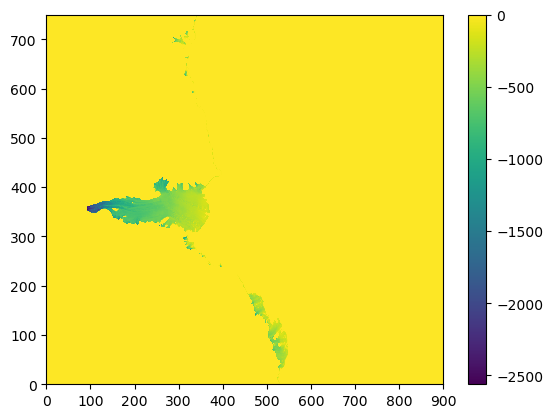

In [ ]:
plt.close()
plt.pcolormesh(ice)
plt.colorbar()
plt.show()

In [ ]:
roms_tmp['bed'] = bed
roms_tmp['ice'] = ice
roms_tmp['mask'] = mask

bathy


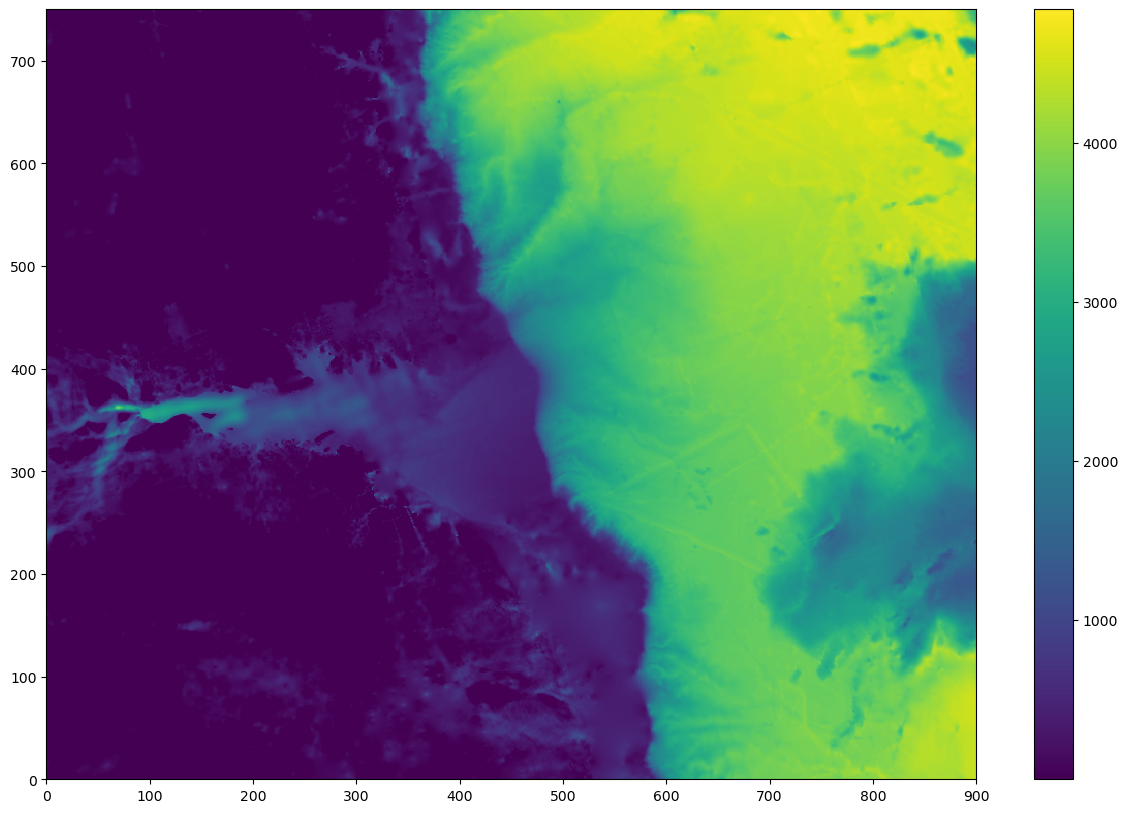

draft


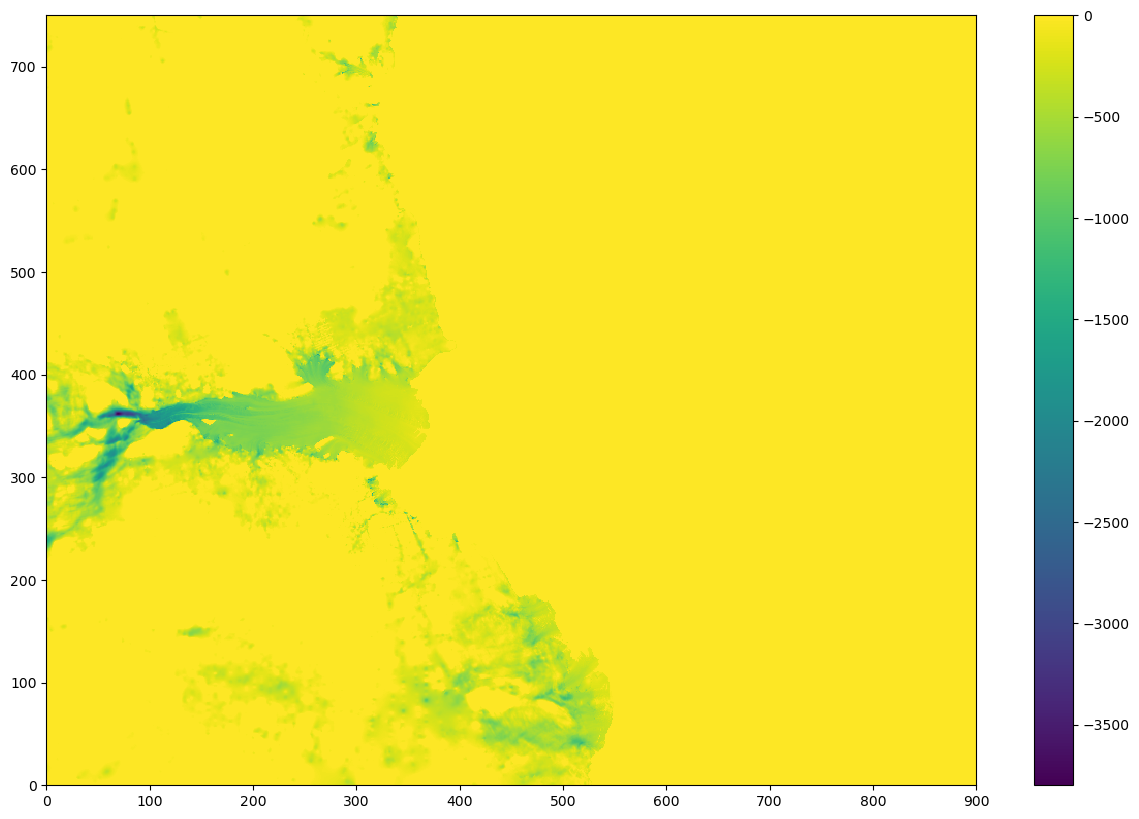

mask_ice


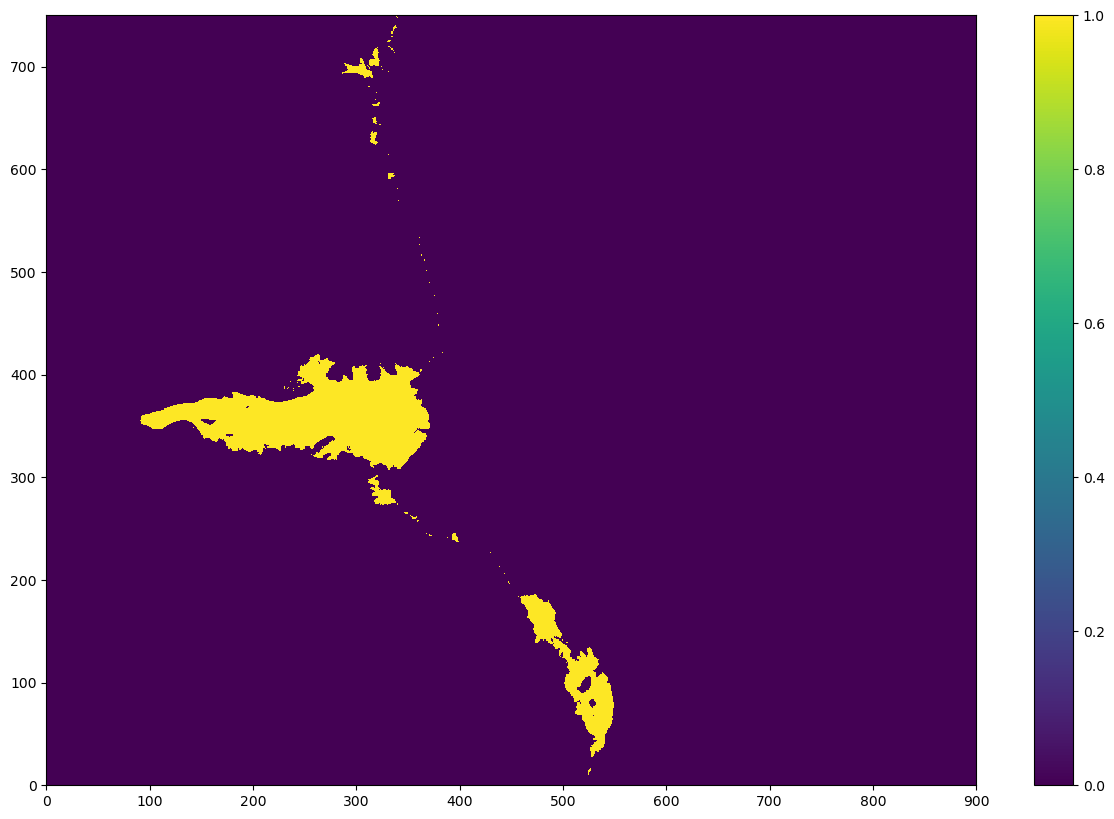

mask_ocean


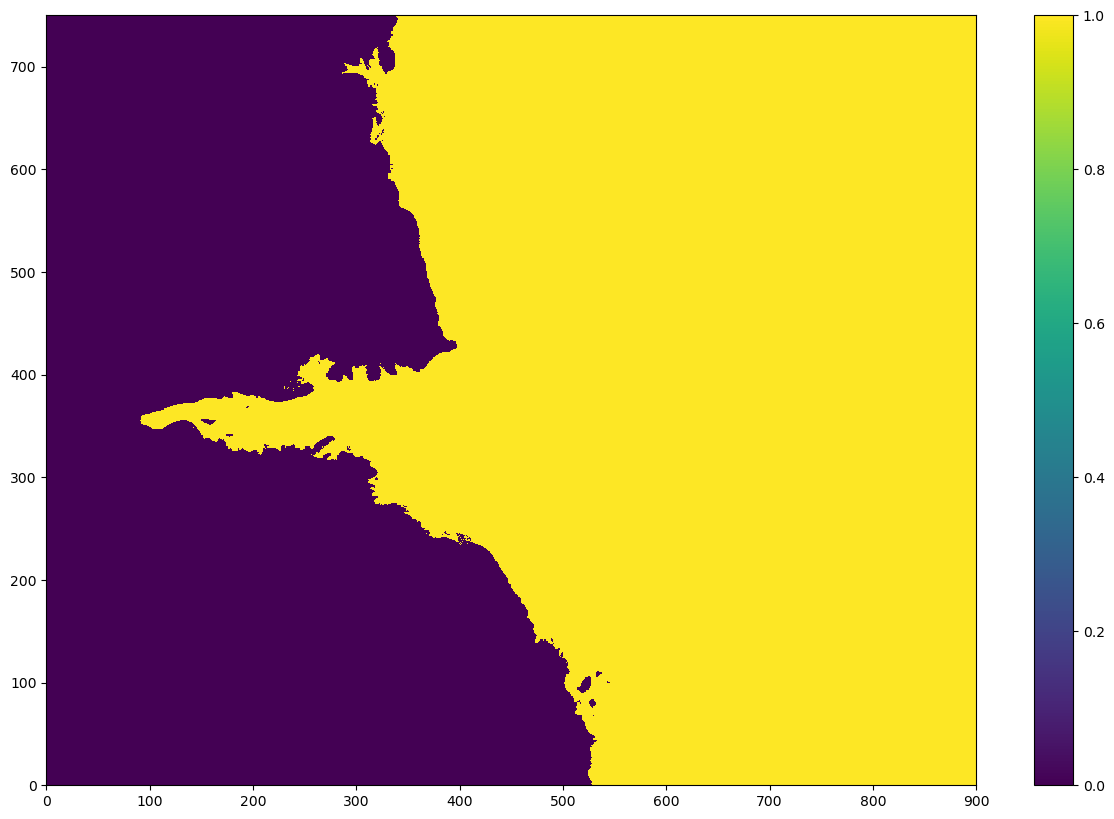

bed


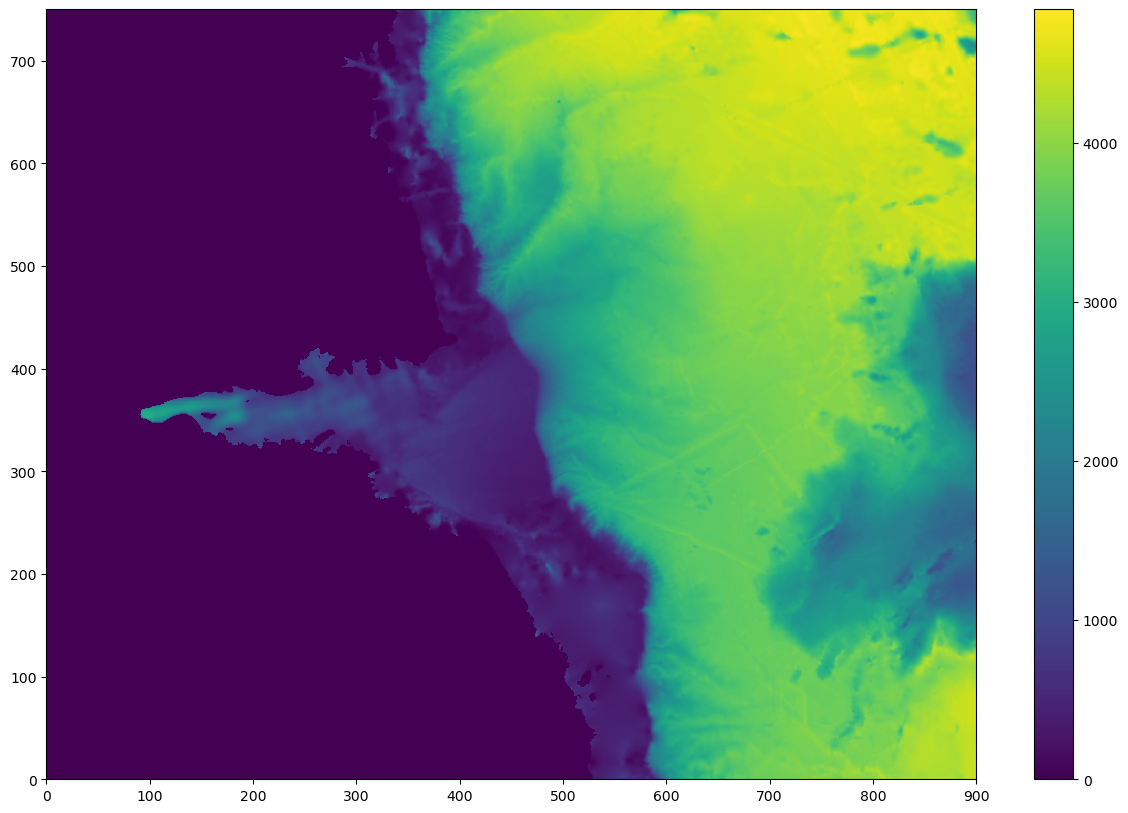

ice


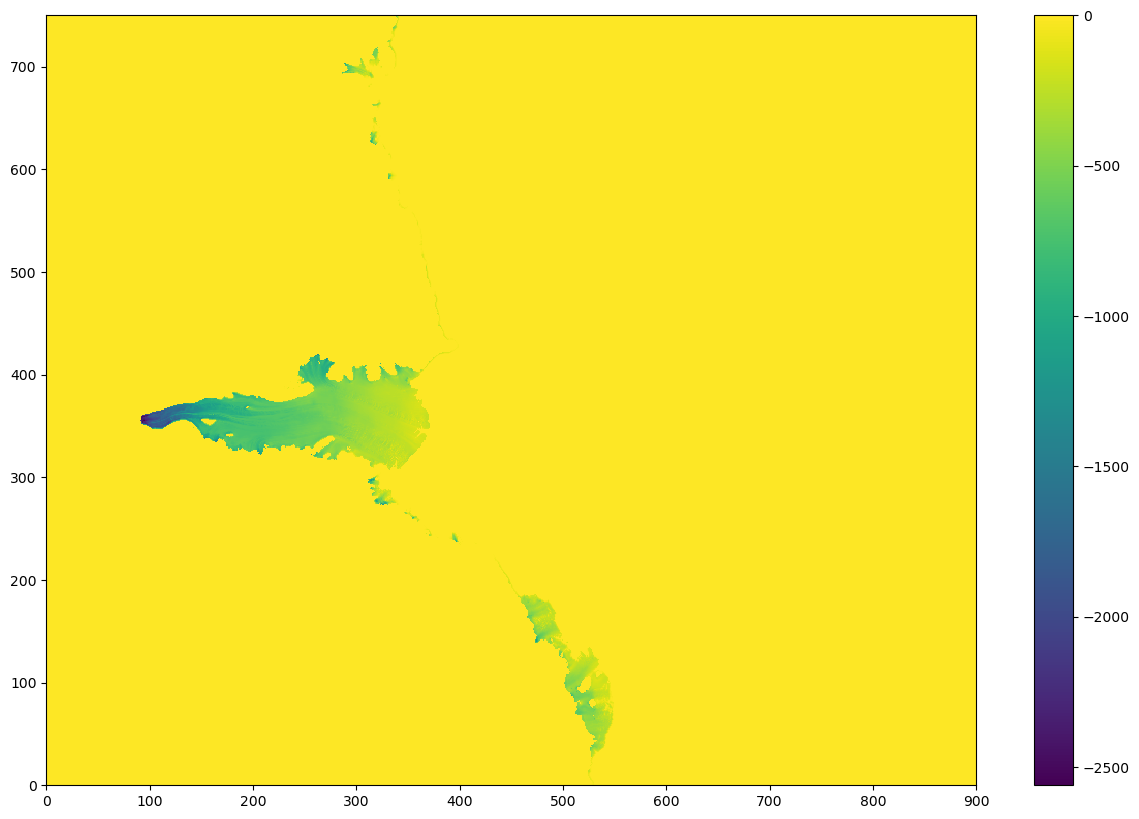

mask


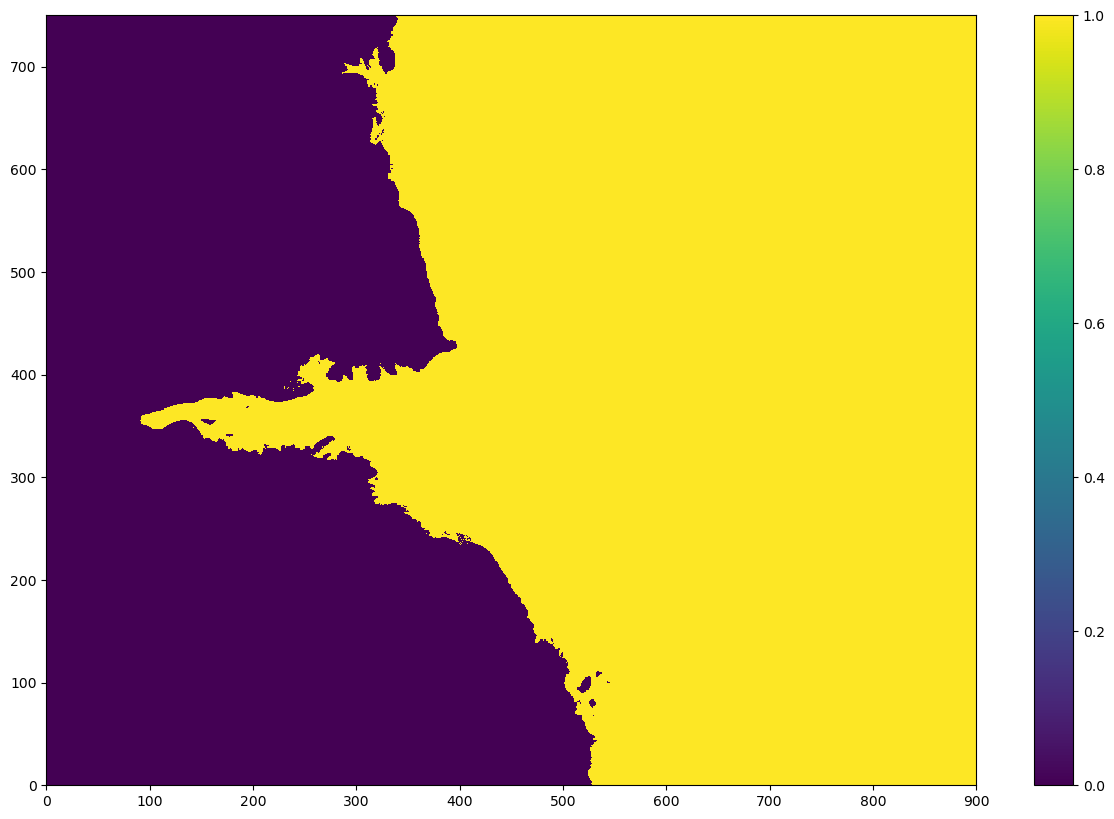

In [ ]:
if plotting:
    plt.close()
    for k,v in roms_tmp.items():
        plt.figure(figsize=(15,10))
        print(k)
        plt.pcolormesh(v)
        plt.colorbar()
        plt.show()

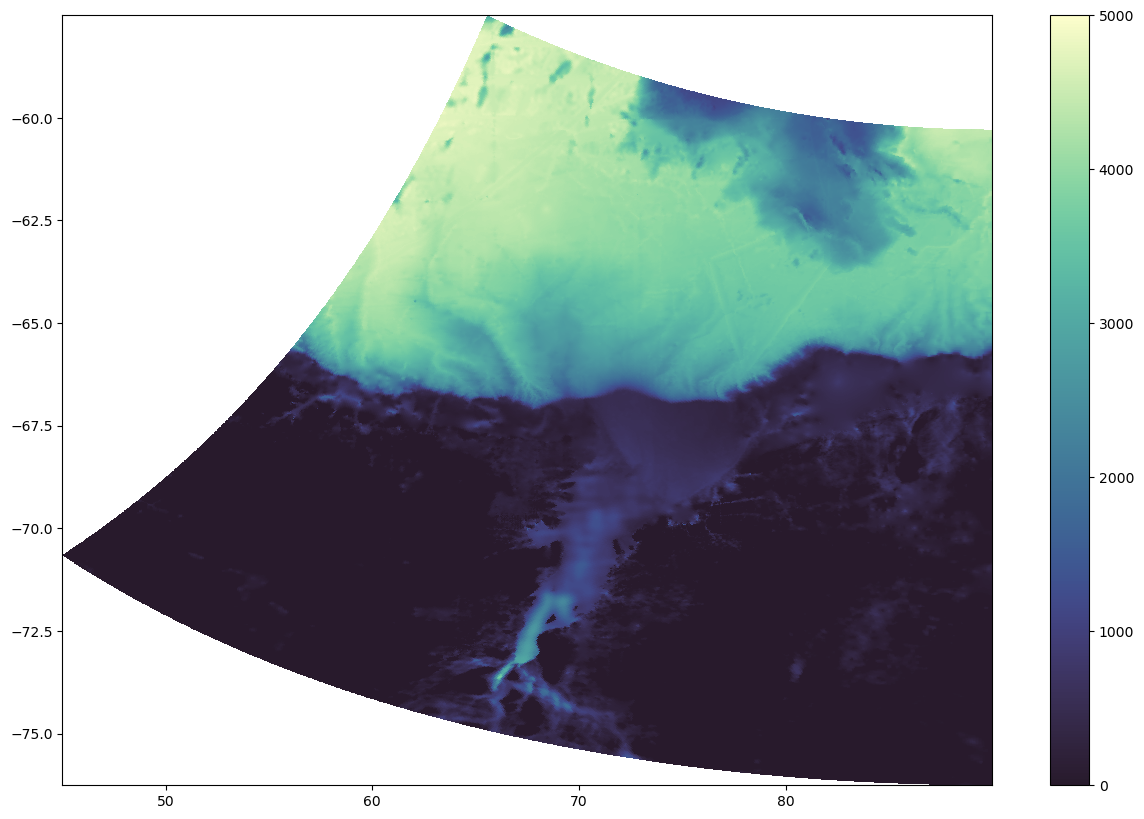

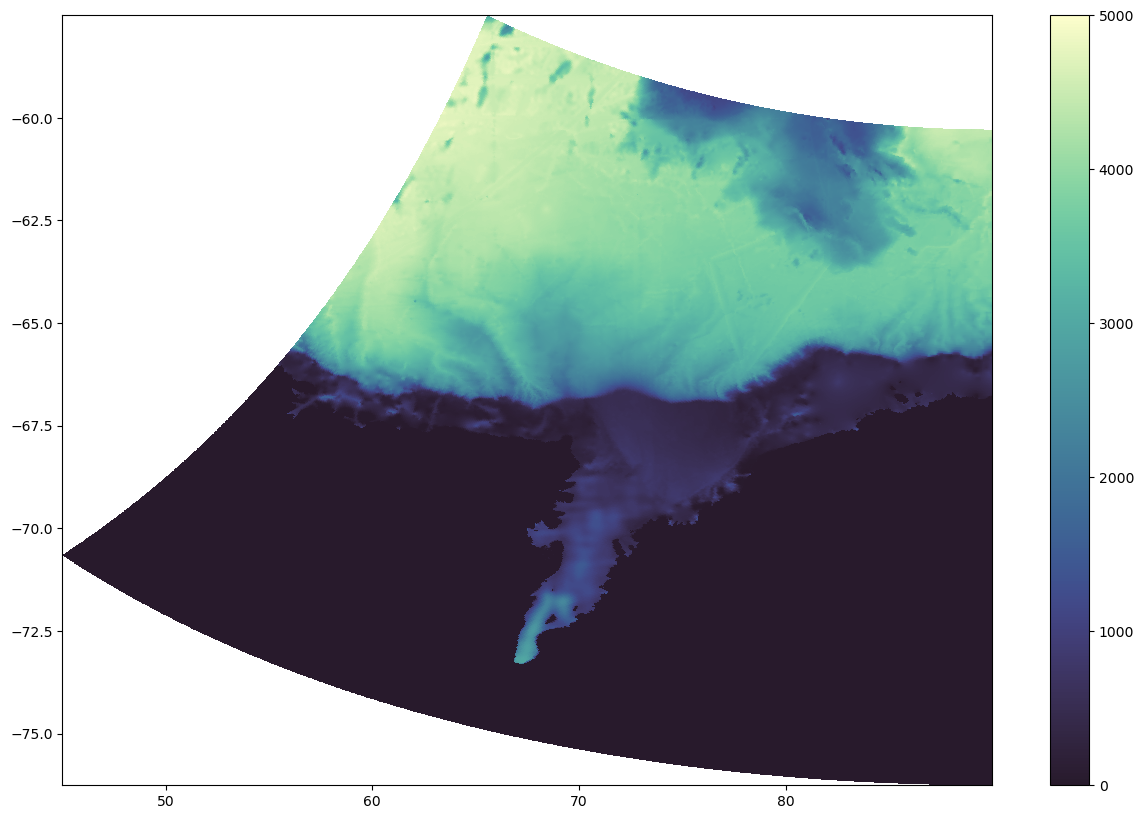

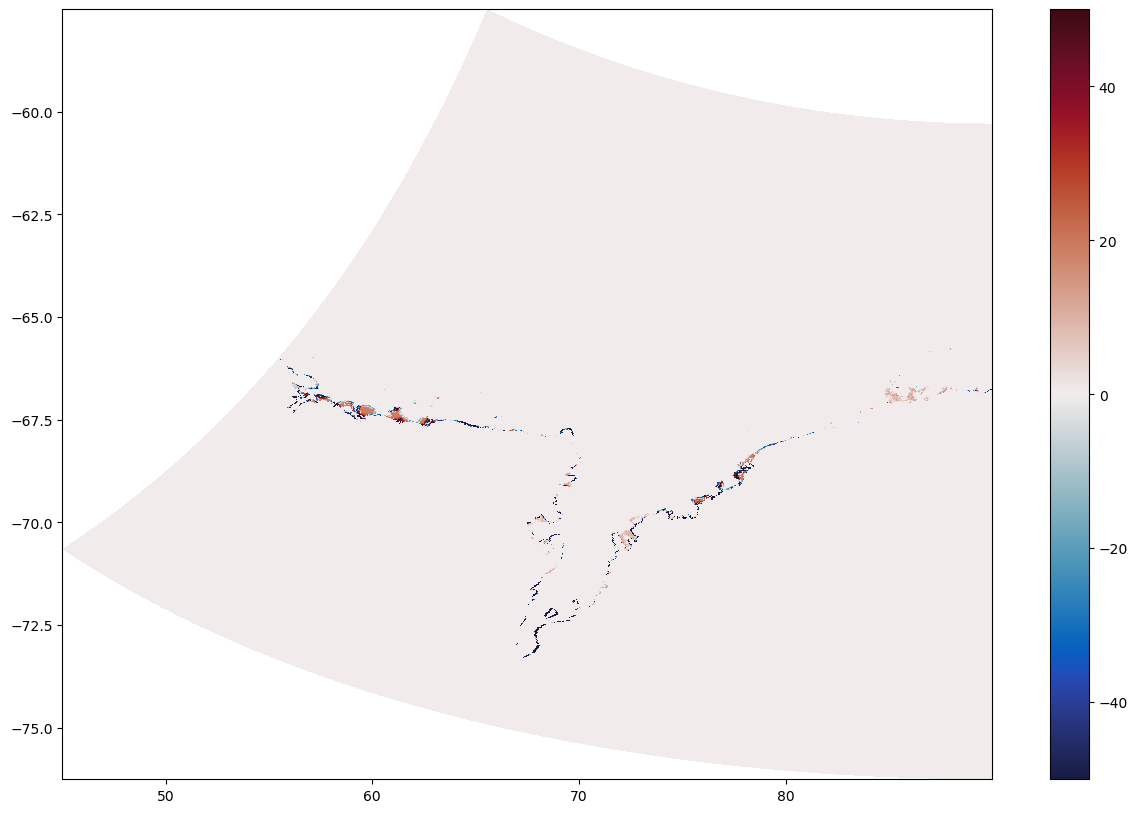

In [ ]:
# plot of chosen subset
fig,ax=plt.subplots(figsize=(15,10))
plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bathy'],vmin=000,vmax=5000,cmap='cmo.deep_r')
# geom.mask.plot.contour(colors='k')
plt.colorbar()
plt.show()
fig,ax=plt.subplots(figsize=(15,10))
plt.pcolormesh(lon_rho,lat_rho,bed,vmin=000,vmax=5000,cmap='cmo.deep_r')
# geom.mask.plot.contour(colors='k')
plt.colorbar()
plt.show()
fig,ax=plt.subplots(figsize=(15,10))
plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bed']*roms_tmp['mask']-roms_tmp['bathy']*roms_tmp['mask'],cmap='cmo.balance',vmin=-50,vmax=50)
# geom.mask.plot.contour(colors='k')
plt.colorbar()


0.0


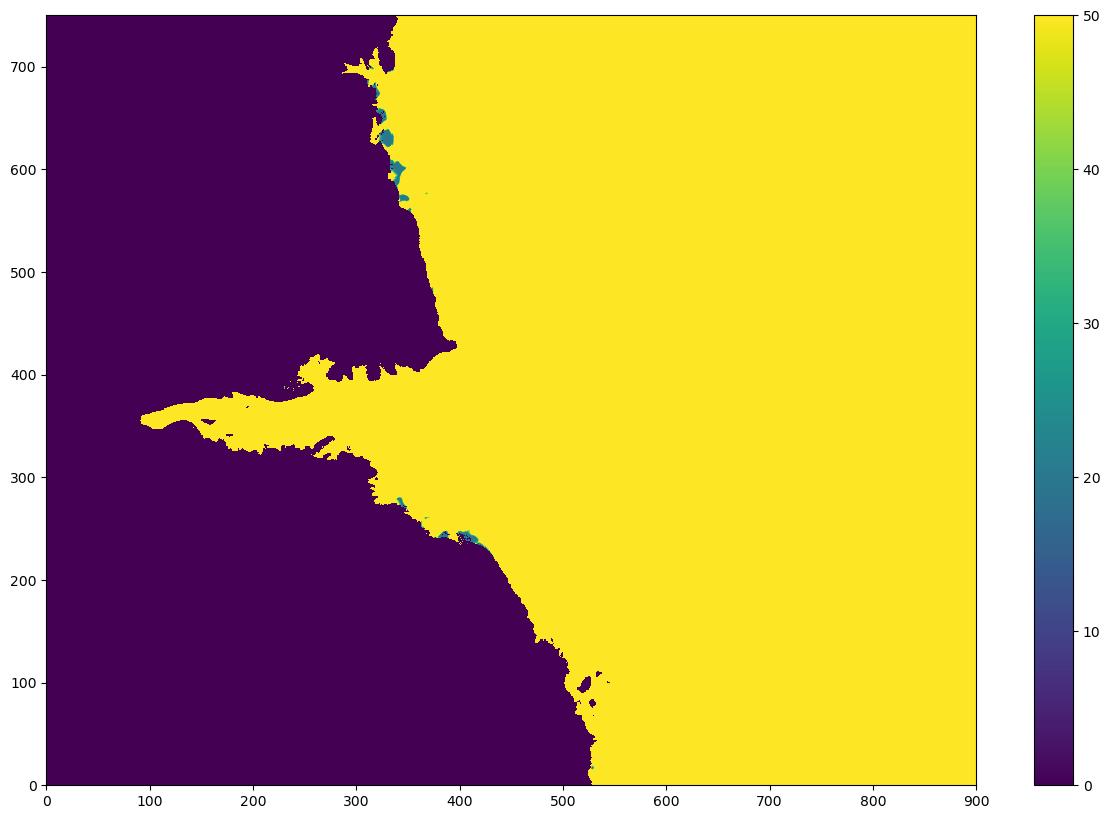

In [ ]:
plt.figure(figsize=(15,10))
plt.pcolormesh(roms_tmp['bed'],vmax=50)
plt.colorbar()
print(min(roms_tmp['bed'].flatten()))

In [ ]:
mask = mask.astype(float)
mindxy = mr*1000
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))

max fast DT in s following CFL:  9.179675102233887


In [ ]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray(int(1),name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array([0, 1], dtype=int),
 'long_name': 'grid type logical switch'})

xl = mr*np.size(lat_rho,1)*1000
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = mr*np.size(lon_rho,0)*1000
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(bed.astype(float),name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})
hraw_da = xr.DataArray(bed_raw.astype(float),name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working unmasked bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(ice.astype(float),name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})
zice_raw_da = xr.DataArray(ice_raw.astype(float),name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'raw unmasked model ice draft at RHO-points', 'units': 'meter'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})


mask_u,mask_v,mask_psi = uvp_masks(mask)

mask_rho_da = xr.DataArray(mask.astype(float),name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi.astype(float),name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u.astype(float),name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v.astype(float),name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pn_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
                'hraw':hraw_da,
                'zice':zice_da,
                'zice':zice_raw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

(290.0, 300.0)

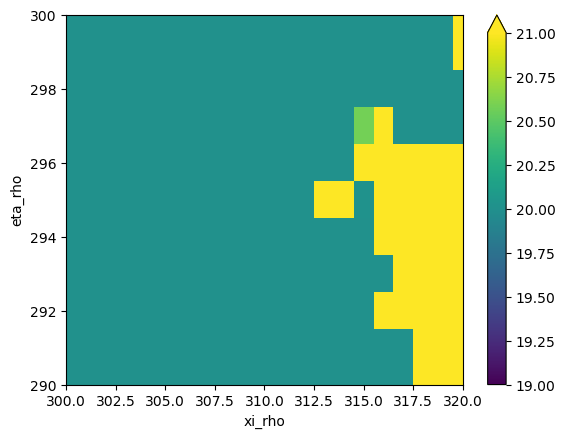

In [ ]:
wct.plot(vmax=20)
plt.xlim(300,320)
plt.ylim(290,300)


In [ ]:
grd.to_netcdf(out_path,unlimited_dims='bath')

In [ ]:

test = xr.open_dataset(out_path)

grd2 = test
test

<xarray.Dataset>
Dimensions:    (eta_rho: 750, xi_rho: 900, eta_psi: 749, xi_psi: 899,
                eta_u: 750, xi_u: 899, eta_v: 749, xi_v: 900)
Dimensions without coordinates: eta_rho, xi_rho, eta_psi, xi_psi, eta_u, xi_u,
                                eta_v, xi_v
Data variables: (12/24)
    spherical  int64 ...
    xl         int64 ...
    el         int64 ...
    angle      (eta_rho, xi_rho) float64 ...
    pm         (eta_rho, xi_rho) float64 ...
    pn         (eta_rho, xi_rho) float64 ...
    ...         ...
    lon_v      (eta_v, xi_v) float64 ...
    lat_v      (eta_v, xi_v) float64 ...
    mask_rho   (eta_rho, xi_rho) float64 ...
    mask_psi   (eta_psi, xi_psi) float64 ...
    mask_u     (eta_u, xi_u) float64 ...
    mask_v     (eta_v, xi_v) float64 ...
Attributes:
    history:  GRID file using make_grid.py,2023-05-06
    type:     ROMS grid file

In [ ]:
# remove isolated cells (lakes and single cell islands)

from contextlib import suppress

def compare_neighbors(arr):
# # test example:
# arr = np.array([[False, False, False, False, False, False],
#                 [False, True, False, True, False, False],
#                 [False, False, False, False, True, False],
#                 [True, False, False, True, True, False],
#                 [False, True, True, True, False, False],
#                 [False, True, False, True, False, False],
#                 [False, True, True, True, False, False]])

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # print(x,y)
        # print(x,y,arr.shape[0],arr.shape[1])
        # print((x<arr.shape[0]) & (y<arr.shape[1]))
        if (x>0) & (y>0) & (x<arr.shape[0]-1) & (y<arr.shape[1]-1):
            # print(x,y)
            if (arr[x-1, y] != item) & (arr[x+1, y] != item) & (arr[x, y+1] != item) & (arr[x, y-1] != item):
                if (arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item):
                    comp_arr[x, y] = True # Isolated cells are set to True
                if ((arr[x-1, y-1] == item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] == item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] == item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] == item)):
                    comp_arr[x, y] = True # find diagonal single cells
    return comp_arr


islands = compare_neighbors(test.mask_rho)

new_mask = grd2.mask_rho.where(~islands,np.logical_not(grd2.mask_rho))



test['mask_rho'] = new_mask

In [ ]:
# #hand editing SIGH
# test['mask_rho'][348,112]=0
# test['mask_rho'][352,112]=0
# test['mask_rho'][351,118]=0
# test['mask_rho'][349,115]=0
# test['mask_rho'][353,112]=0
# test['mask_rho'][353,111]=0
# test['mask_rho'][347,112]=0
# test['mask_rho'][347,111]=0
# test['mask_rho'][352,111]=0



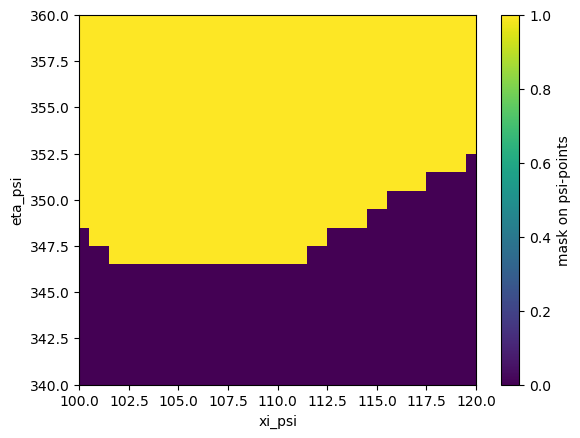

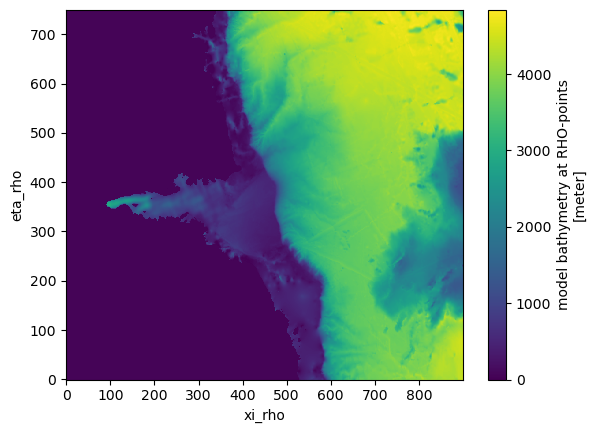

In [ ]:
test.mask_psi.plot()
plt.xlim(100,120)
plt.ylim(340,360)
plt.show()
test.h.where(test.mask_rho,min_depth).plot()
# plt.xlim(100,120)
# plt.ylim(340,360)

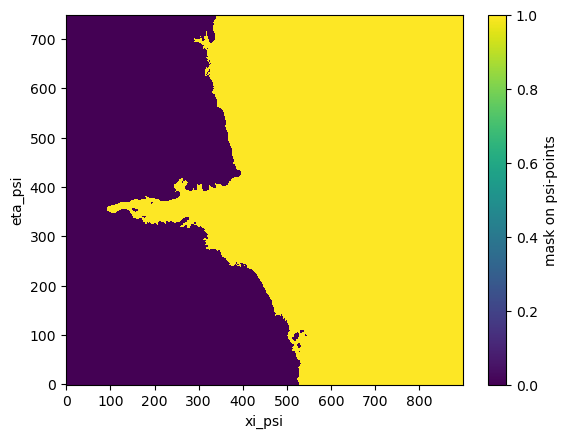

In [ ]:
test.mask_psi.plot()
# plt.xlim(100,120)
# plt.ylim(340,360)

In [ ]:


min_depth=50.0

zice_corrected  = test.zice.where(test.mask_rho,0) # set values of zice outside of ocean to 0
zice_corrected = zice_corrected.where(zice_corrected<=0,0) # set zice values to be max of 0.

h_corrected = test.h.where(np.isfinite(test.h),0) # set bathy nan values to 0
h_corrected  = h_corrected.where(test.mask_rho,min_depth) # set bathy outside of mask to min_depth
h_corrected  = h_corrected.where(h_corrected>=min_depth,min_depth) # set bathy below min_depth to min_depth

h_corrected = h_corrected.where(~(h_corrected+zice_corrected<min_depth),-zice_corrected+min_depth) # make bathy deeper where wct < min_depth

grd2['h'] = h_corrected
grd2['zice'] = zice_corrected

grd2.to_netcdf('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd_v2.nc',unlimited_dims='bath')


In [ ]:
wct

<xarray.DataArray (eta_rho: 750, xi_rho: 900)>
array([[  50.        ,   50.        ,   50.        , ..., 4411.83154297,
        4413.79443359, 4414.29785156],
       [  50.        ,   50.        ,   50.        , ..., 4415.18798828,
        4417.37939453, 4416.59814453],
       [  50.        ,   50.        ,   50.        , ..., 4415.75146484,
        4418.91894531, 4419.29882812],
       ...,
       [  50.        ,   50.        ,   50.        , ..., 3272.2956543 ,
        3232.93359375, 3198.36279297],
       [  50.        ,   50.        ,   50.        , ..., 3270.69799805,
        3233.23144531, 3198.74121094],
       [  50.        ,   50.        ,   50.        , ..., 3261.34912109,
        3223.94506836, 3189.19384766]])
Dimensions without coordinates: eta_rho, xi_rho

In [ ]:
# some more post smoothing
rx0in = 0.3
max_iter = 150
Area = 1/(grd3.pm*grd3.pn)

grd3 = xr.open_dataset('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd_v2.nc')
# smooth bathy again, since you just introduced steps and ensure min depth after

wct = grd3.h+grd3.zice
bed = grd3.h

wct_new, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct.values,rx0in,Area,max_iter)

bed = -grd3.zice + wct_new
ii = (bed + ice < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

bed = bed*mask #final is masked

# set to min_depth
bed[bed<min_depth] = min_depth

Old Max Roughness value is:  0.774588483650786


In [ ]:

grd3['h'] = bed
grd3.to_netcdf('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd_v3.nc',unlimited_dims='bath')

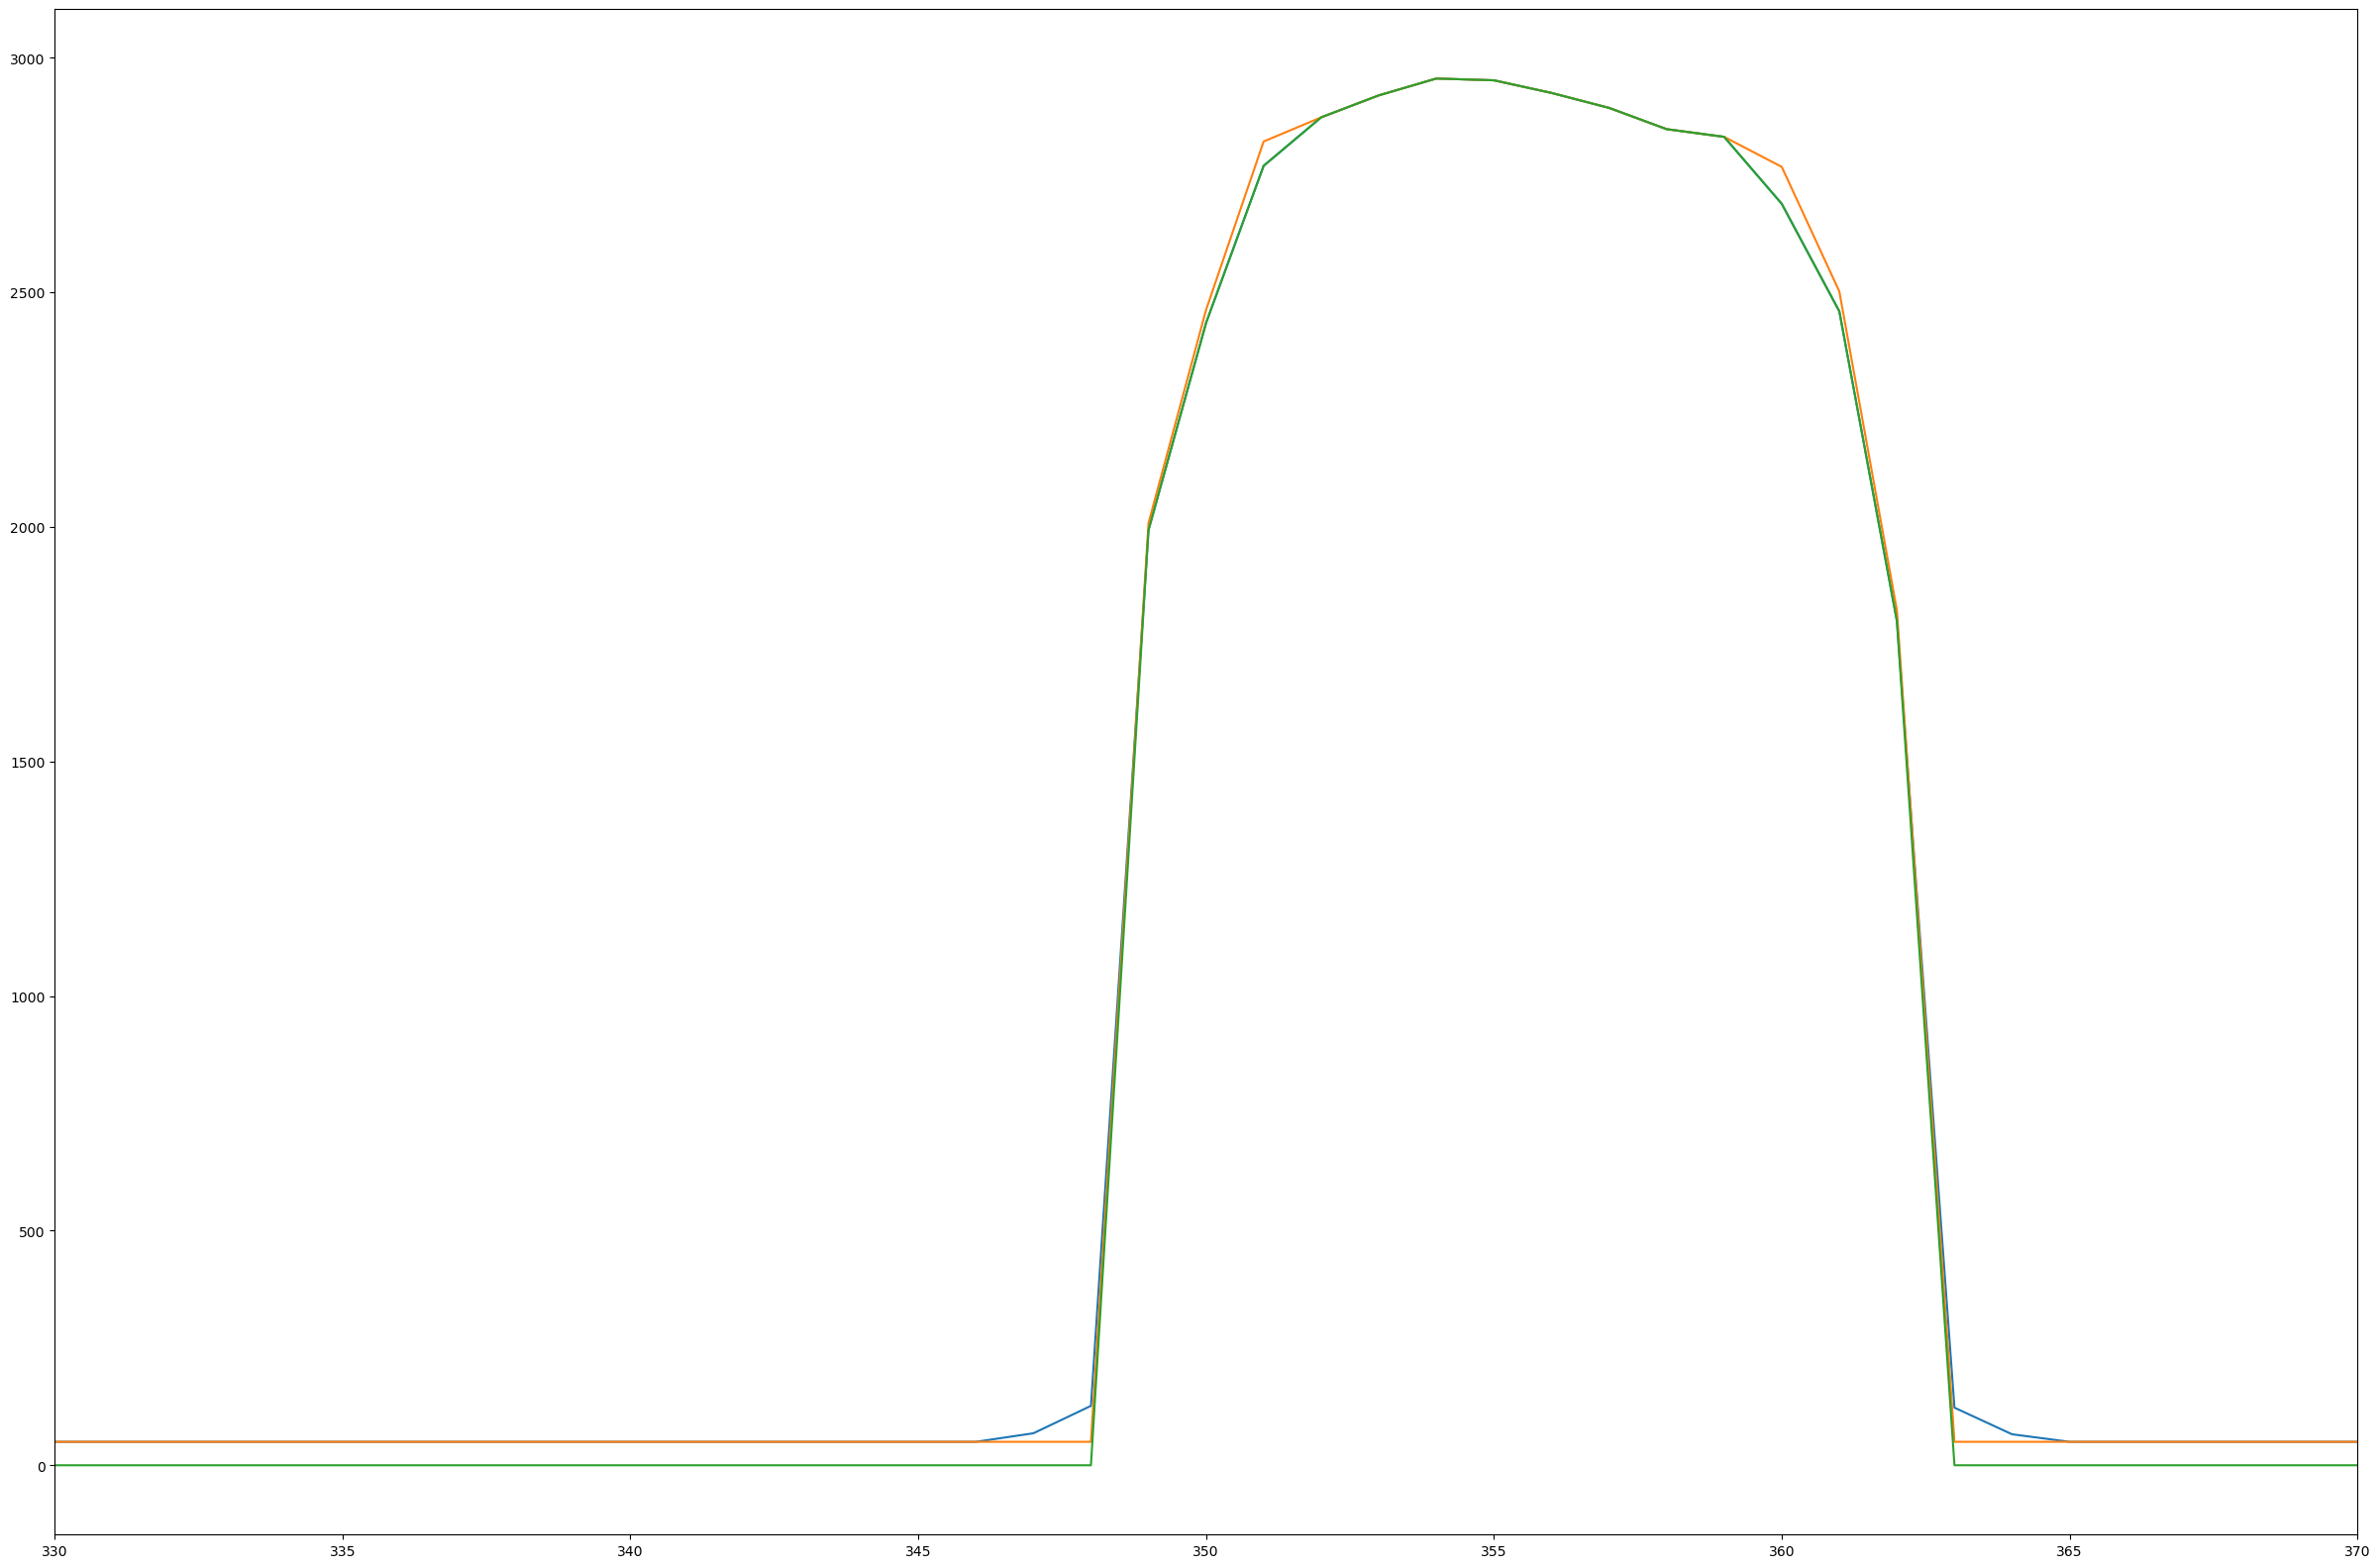

(330.0, 370.0)

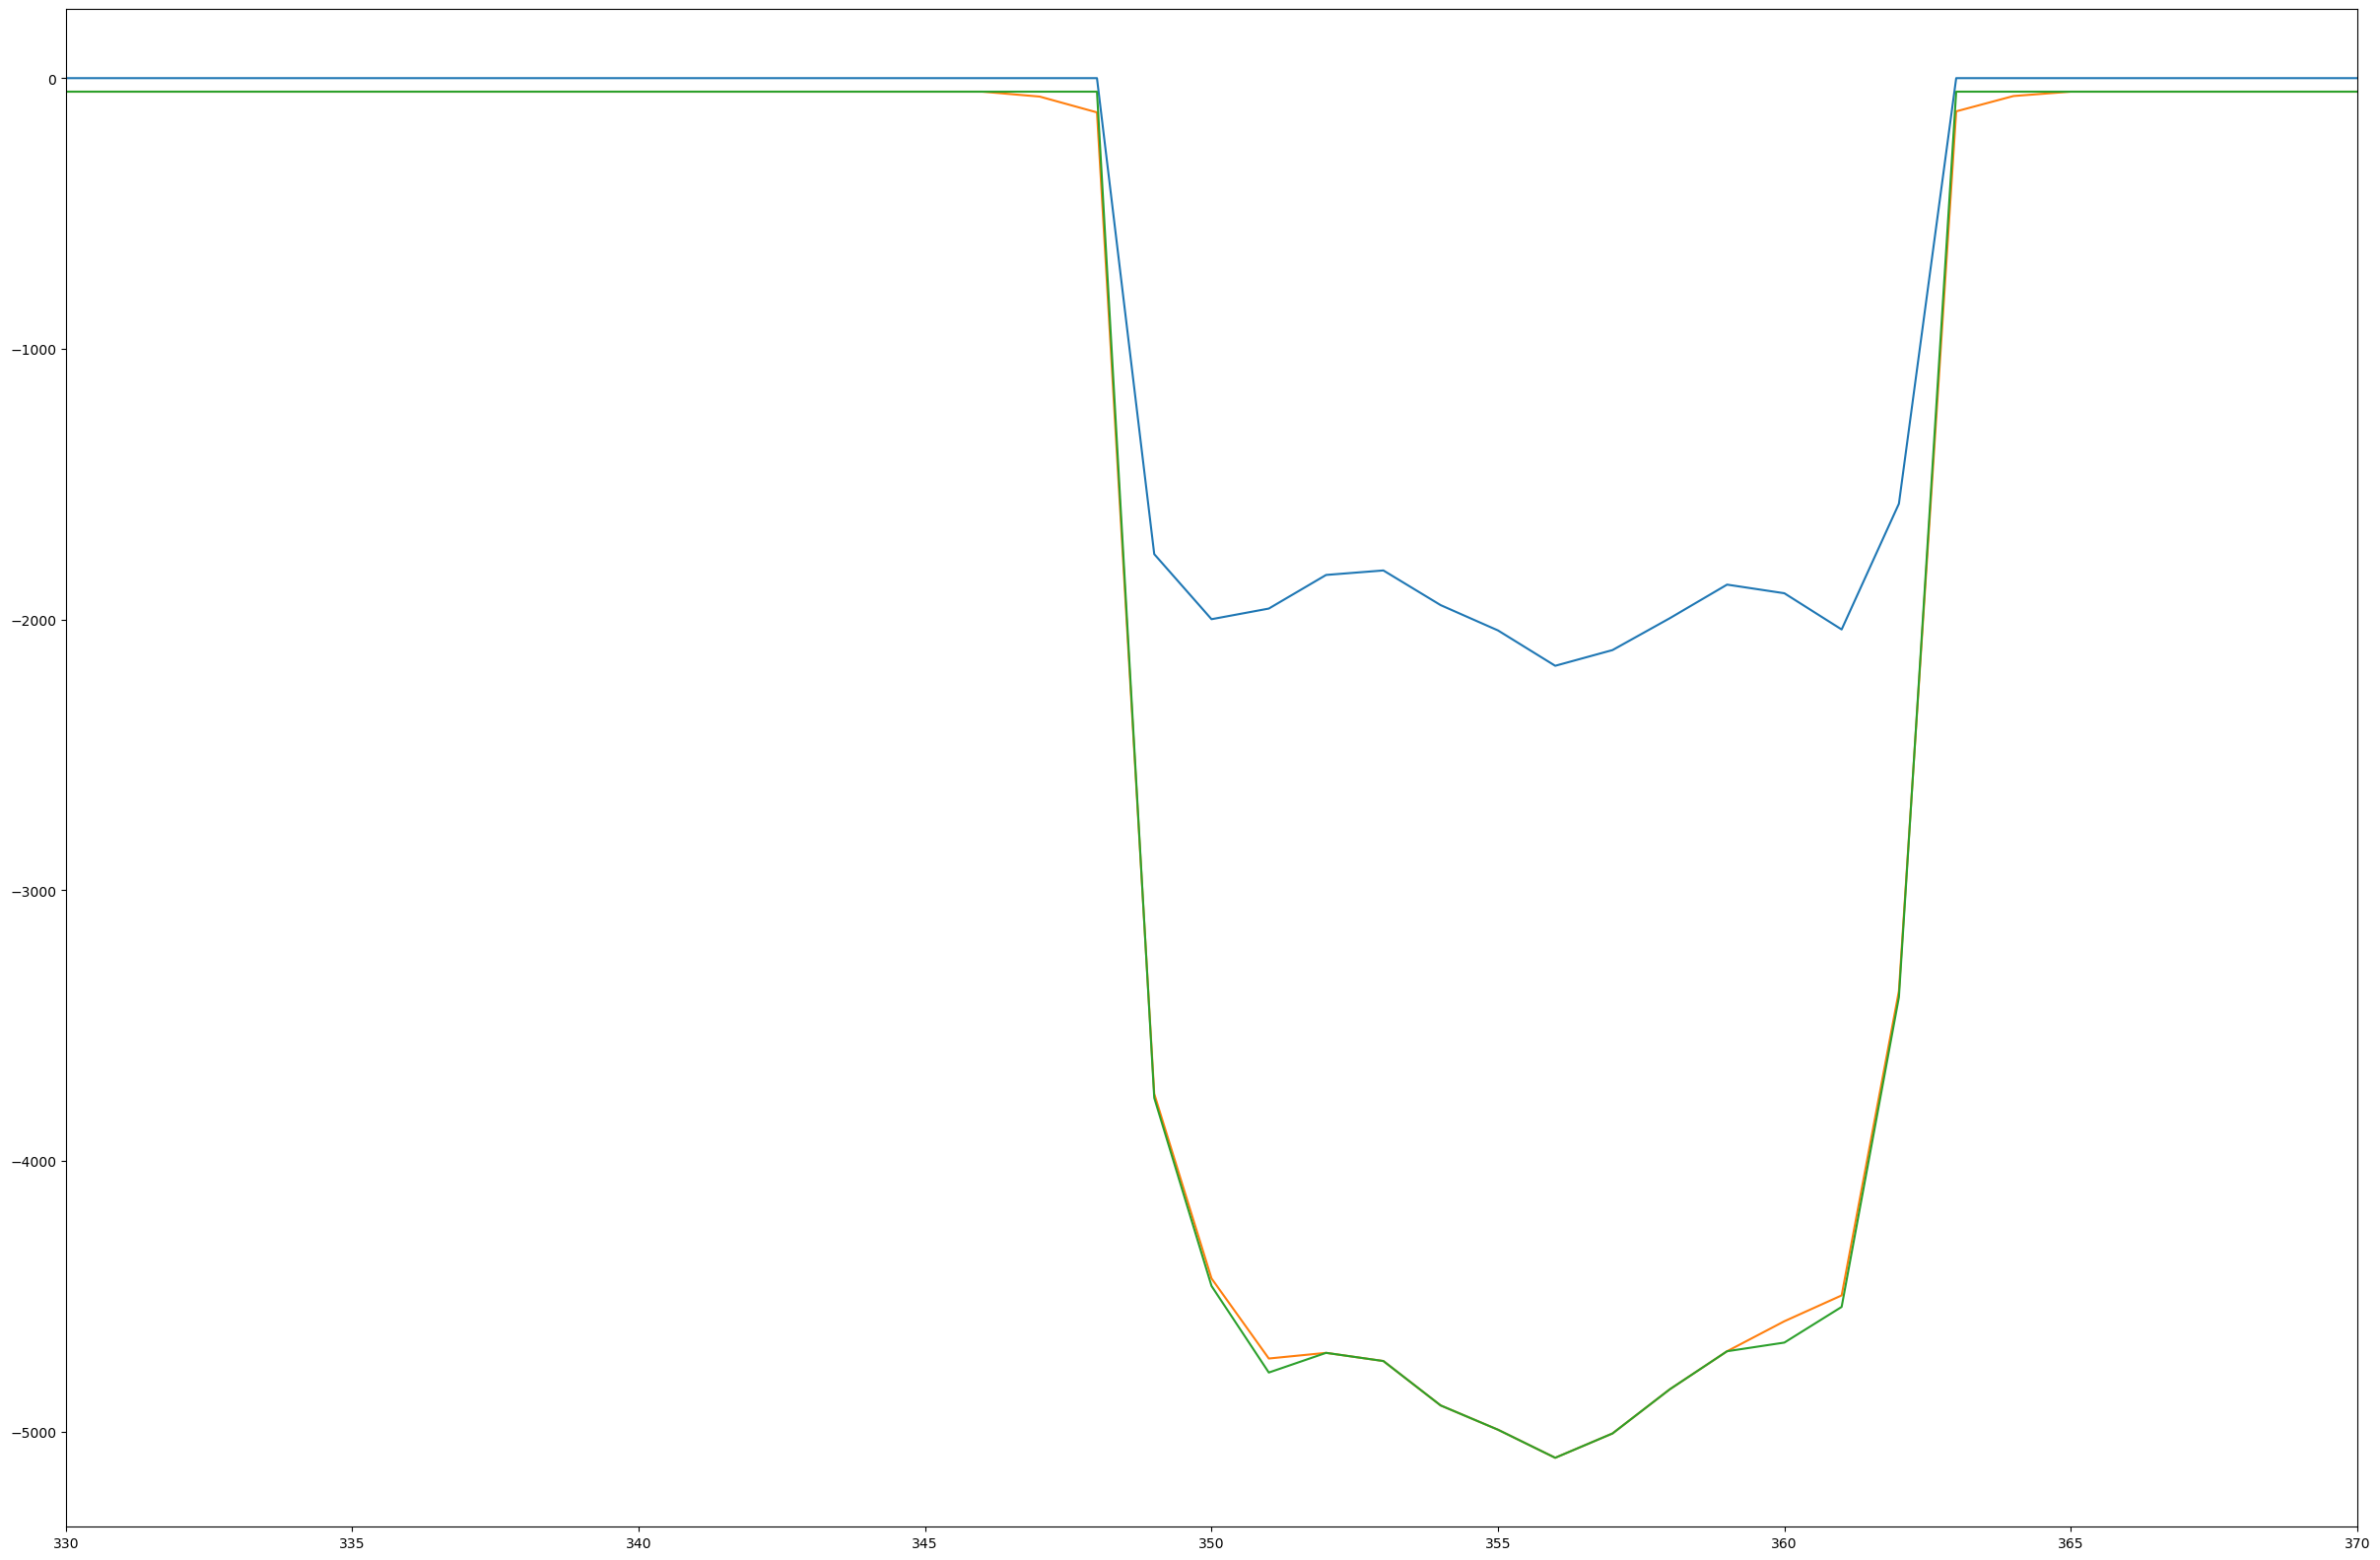

In [ ]:
plt.figure(figsize=(30,20))
# plt.pcolormesh((bed-grd3.h)*grd3.mask_rho)
# plt.colorbar()
# plt.xlim(100,140)
# plt.ylim(330,370)
plt.plot(bed[:,100])
plt.plot(grd3.h[:,100])
plt.plot(bed[:,100]*grd3.mask_rho[:,100])
plt.xlim(330,370)
plt.show()
plt.figure(figsize=(30,20))
plt.plot(grd3.zice[:,100])
plt.plot(grd3.zice[:,100]-bed[:,100])
plt.plot(grd3.zice[:,100]-grd3.h[:,100])

plt.xlim(330,370)



In [ ]:
TESTING STOP

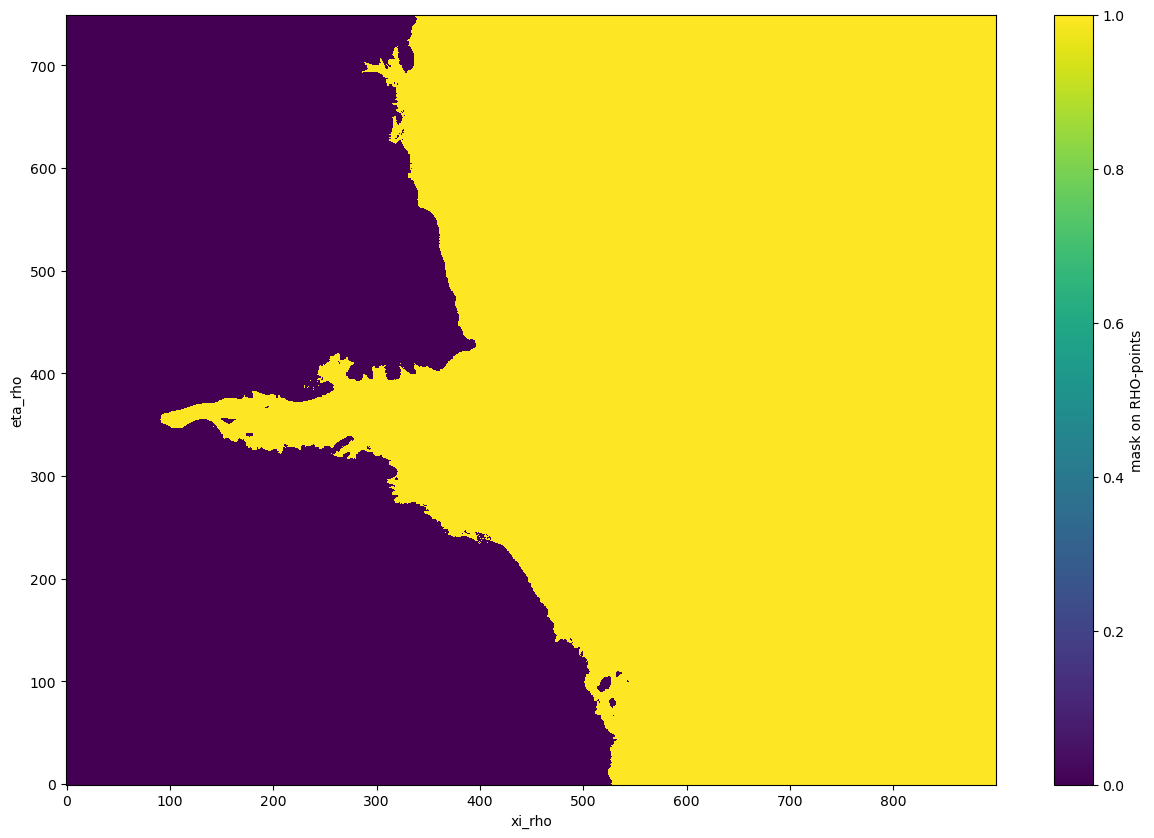

In [ ]:


plt.figure(figsize=(15,10))
grd2.mask_rho.plot()



In [ ]:
from contextlib import suppress

def compare_neighbors(arr):
# # test example:
# arr = np.array([[False, False, False, False, False, False],
#                 [False, True, False, True, False, False],
#                 [False, False, False, False, True, False],
#                 [True, False, False, True, True, False],
#                 [False, True, True, True, False, False],
#                 [False, True, False, True, False, False],
#                 [False, True, True, True, False, False]])

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # print(x,y)
        # print(x,y,arr.shape[0],arr.shape[1])
        # print((x<arr.shape[0]) & (y<arr.shape[1]))
        if (x>0) & (y>0) & (x<arr.shape[0]-1) & (y<arr.shape[1]-1):
            # print(x,y)
            if (arr[x-1, y] != item) & (arr[x+1, y] != item) & (arr[x, y+1] != item) & (arr[x, y-1] != item):
                if (arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item):
                    comp_arr[x, y] = True # Isolated cells are set to True
                if ((arr[x-1, y-1] == item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] == item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] == item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] == item)):
                    comp_arr[x, y] = True # find diagonal single cells
    return comp_arr

# # test example:
# arr = np.array([[False, False, False, False, False, False,False],
#                 [False, True, False, True, False, False,False],
#                 [False, False, False, False, True, False,False],
#                 [True, False, False, True, True, False,False],
#                 [False, True, True, True, False, False,False],
#                 [False, True, False, True, False, True,False],
#                 [False, True, True, True, False, False,True]])
# test = compare_neighbors(arr)
test = compare_neighbors(grd2.mask_rho)

print( test)



[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


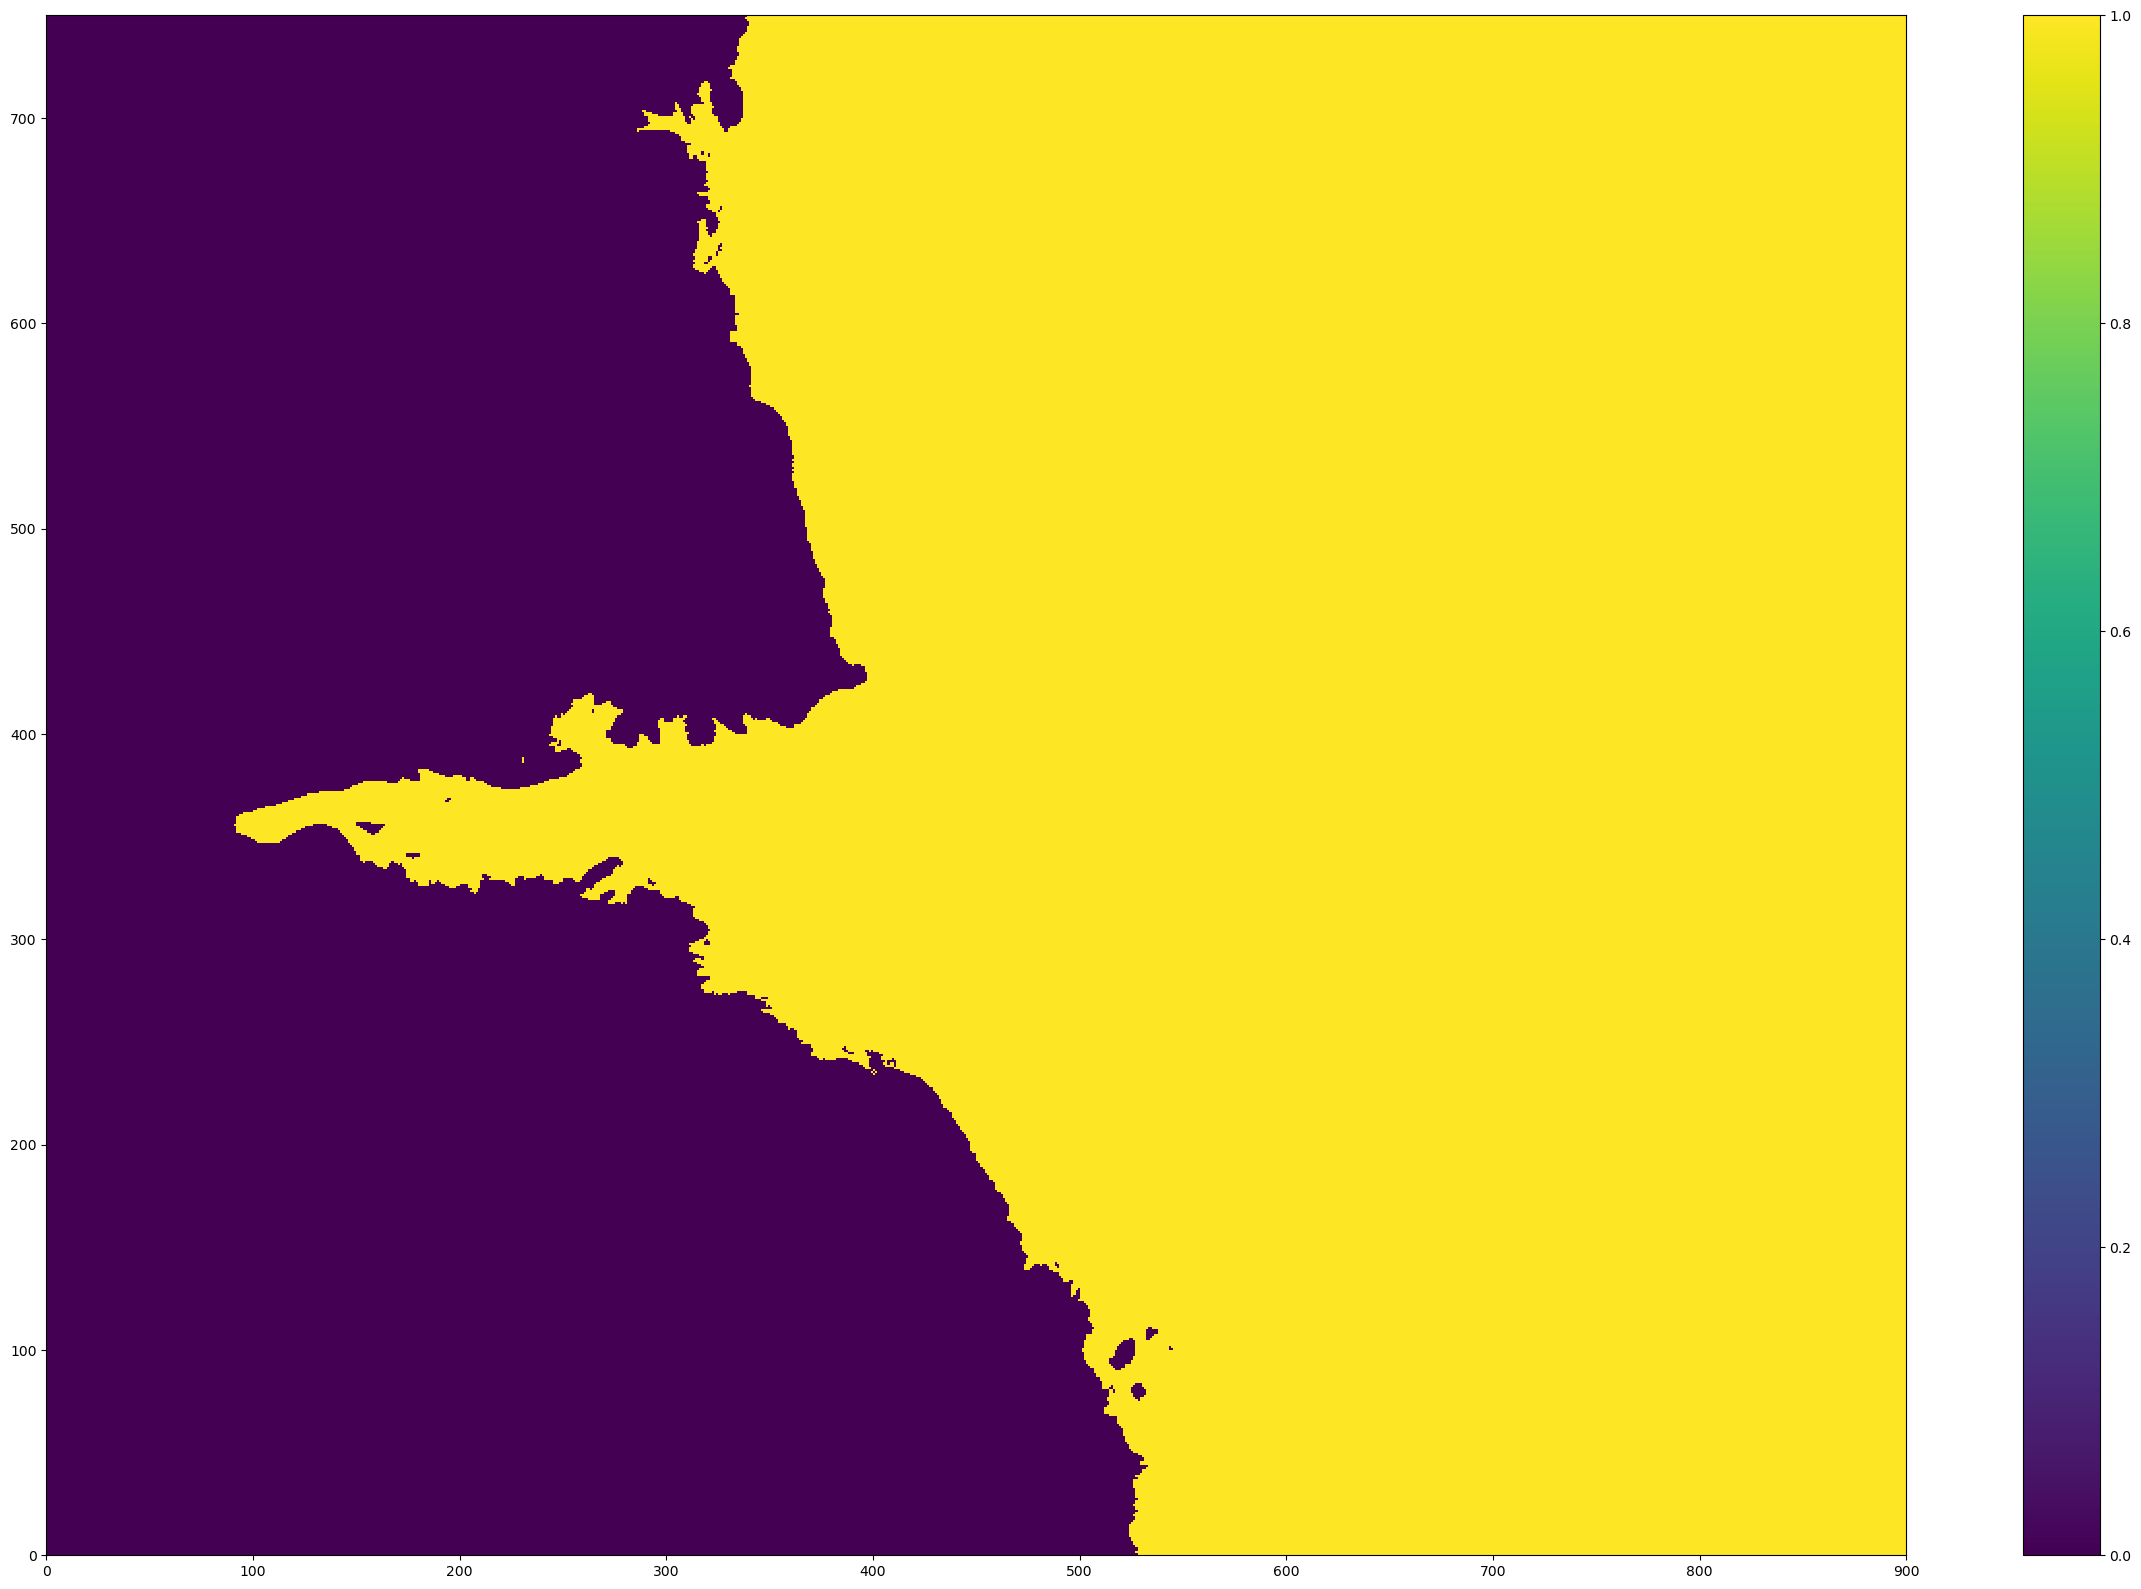

In [ ]:
new_mask = grd2.mask_rho.where(~test,np.logical_not(grd2.mask_rho))
plt.figure(figsize=(30,20))

plt.pcolormesh(new_mask)
plt.colorbar()

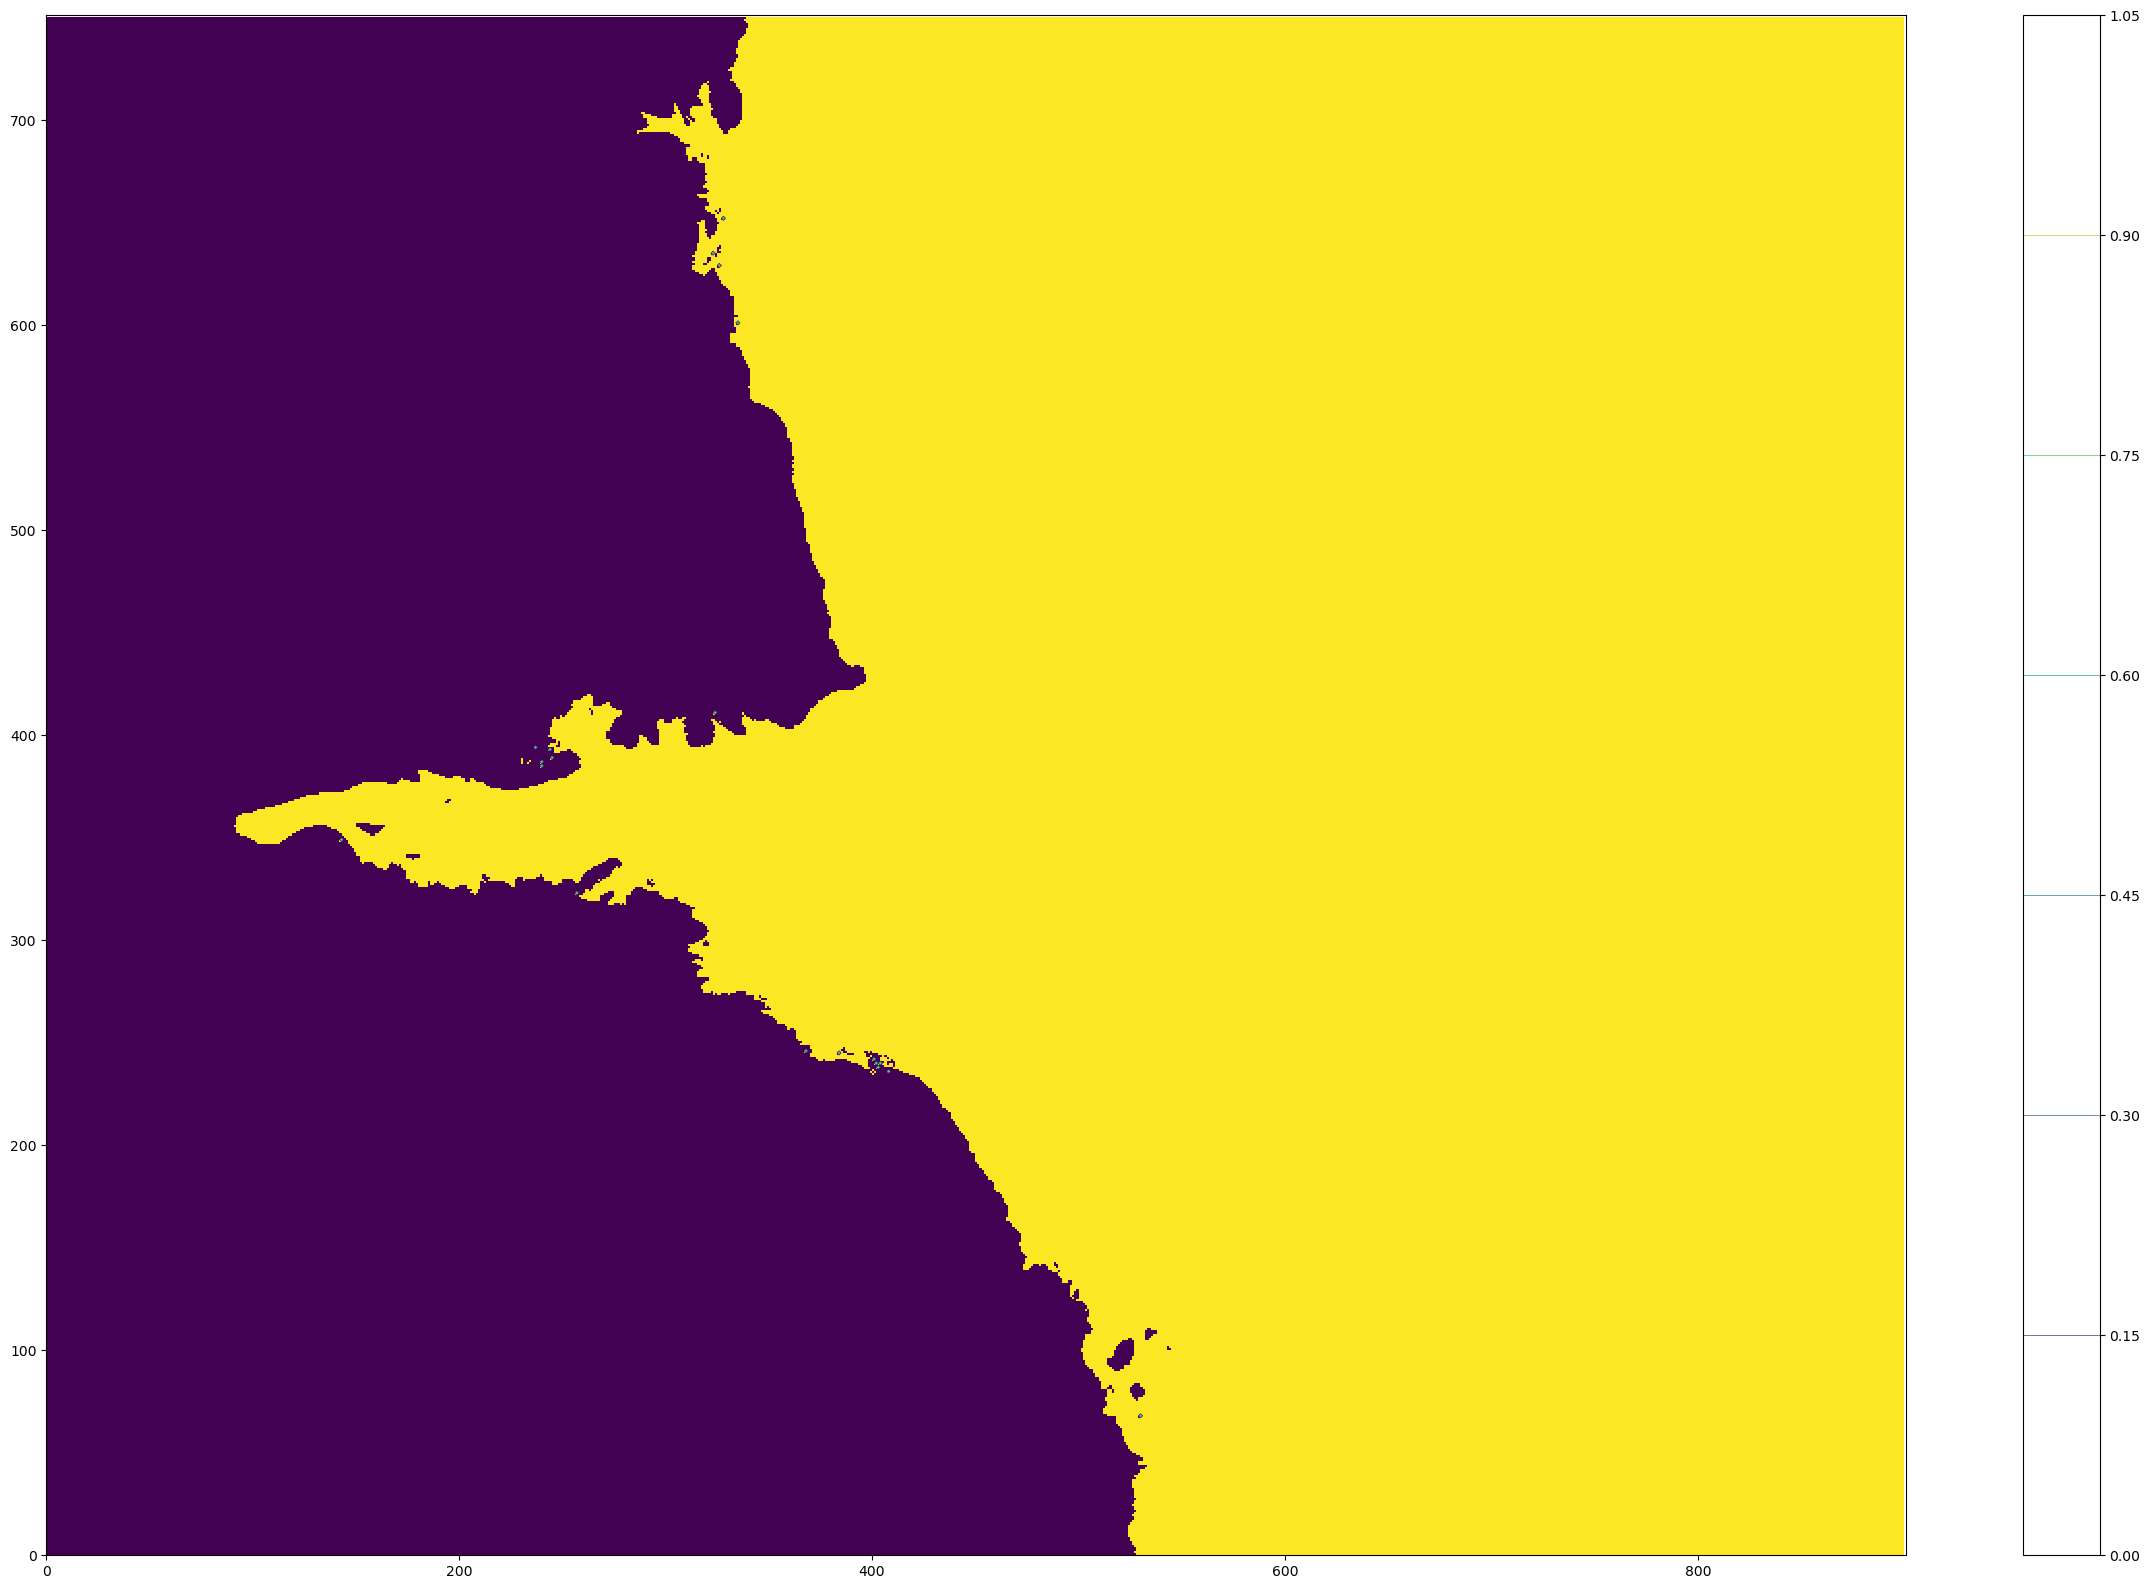

In [ ]:
plt.figure(figsize=(30,20))
plt.pcolormesh(grd2.mask_rho)
plt.contour(np.pad(test,1,mode='edge')*1.0,linewidths=0.5)
plt.colorbar()

In [ ]:


grd2.to_netcdf('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd_v2.nc',unlimited_dims='bath')
